# Import Data

In [27]:
from cvx.covariance.ewma import iterated_ewma, _ewma_cov, _ewma_mean
from cvx.covariance.combination import from_sigmas

from predictorStarter import * # this file contains the import of every dataset, libraries needed and the initial plotting of the data
from predictorsImplementation import * # this file contains the implementation of the predictors ( one function implementation for each predictor)

import cvxpy as cp
from pandas.tseries.offsets import BDay

recover the list of volatilities, log likelihood, regret ecc

In [28]:
# these are all dictionaries that contain the volatility predictions for each predictor; every dictionaries contains the volatility predcitions for each stock(AAPL,IBM,MCD)

%store -r rw_volatilities
%store -r ewma_volatilities
%store -r mgarch_volatilities
%store -r hybrid_rw_volatilities
%store -r hybrid_ewma_volatilities
%store -r hybrid_mgarch_volatilities
%store -r real_volatilities

print("shape of volatilies: ", len(rw_volatilities['AAPL']))
# print the whole first element of the dictionary
print("the first element of the dictionary is: ", next(iter(rw_volatilities['AAPL'])))

# assert that every dictionaries have the same length
assert len(rw_volatilities['AAPL']) == len(ewma_volatilities['AAPL']) == len(mgarch_volatilities['AAPL']) == len(hybrid_rw_volatilities['AAPL']) == len(hybrid_ewma_volatilities['AAPL']) == len(hybrid_mgarch_volatilities['AAPL']) == len(real_volatilities['AAPL'])

print("length of the dictionary is: ", rw_volatilities)

# assert that the keys of the dictionaries are the same
assert rw_volatilities.keys() == ewma_volatilities.keys() == mgarch_volatilities.keys() == hybrid_rw_volatilities.keys() == hybrid_ewma_volatilities.keys() == hybrid_mgarch_volatilities.keys() == real_volatilities.keys()

print("keys of the dictionary are: ", rw_volatilities.keys())

# assert that every key of the dictionary has 308 elements
for key in rw_volatilities.keys():
    assert len(rw_volatilities[key]) == len(ewma_volatilities[key]) == len(mgarch_volatilities[key]) == len(hybrid_rw_volatilities[key]) == len(hybrid_ewma_volatilities[key]) == len(hybrid_mgarch_volatilities[key]) == len(real_volatilities[key])

print("shape of the dictionary is: ", len(rw_volatilities['AAPL']))

# assert that every key of every dictionary starts with the same timestamp
for key in rw_volatilities.keys():
    assert next(iter(rw_volatilities[key])) == next(iter(ewma_volatilities[key])) == next(iter(mgarch_volatilities[key])) == next(iter(hybrid_rw_volatilities[key])) == next(iter(hybrid_ewma_volatilities[key])) == next(iter(hybrid_mgarch_volatilities[key])) == next(iter(real_volatilities[key]))

# print the timestamp of the first element of every dictionary
first_timestamp = next(iter(rw_volatilities['AAPL']))

print("timestamp of the first element of the dictionary is: ", first_timestamp)

# save the start date of the predictions
start_date = first_timestamp
end_date = list(rw_volatilities['AAPL'].keys())[-1]

print("start date of the predictions is: ", start_date)
print("end date of the predictions is: ", end_date)

shape of volatilies:  656
the first element of the dictionary is:  2021-10-12 00:00:00
length of the dictionary is:  {'AAPL': {Timestamp('2021-10-12 00:00:00'): 0.012158517406485445, Timestamp('2021-10-13 00:00:00'): 0.011913319619805237, Timestamp('2021-10-14 00:00:00'): 0.012391247142202048, Timestamp('2021-10-15 00:00:00'): 0.012226907317129164, Timestamp('2021-10-18 00:00:00'): 0.012210349605150541, Timestamp('2021-10-19 00:00:00'): 0.012333073634306687, Timestamp('2021-10-20 00:00:00'): 0.012119801150428414, Timestamp('2021-10-21 00:00:00'): 0.01190466795301022, Timestamp('2021-10-22 00:00:00'): 0.011738710730769783, Timestamp('2021-10-25 00:00:00'): 0.01154157045206587, Timestamp('2021-10-26 00:00:00'): 0.011383584786026111, Timestamp('2021-10-27 00:00:00'): 0.011218115906871348, Timestamp('2021-10-28 00:00:00'): 0.011872652620304538, Timestamp('2021-10-29 00:00:00'): 0.012104102833823112, Timestamp('2021-11-01 00:00:00'): 0.011967521324699732, Timestamp('2021-11-02 00:00:00'): 0

TRIAL CODE

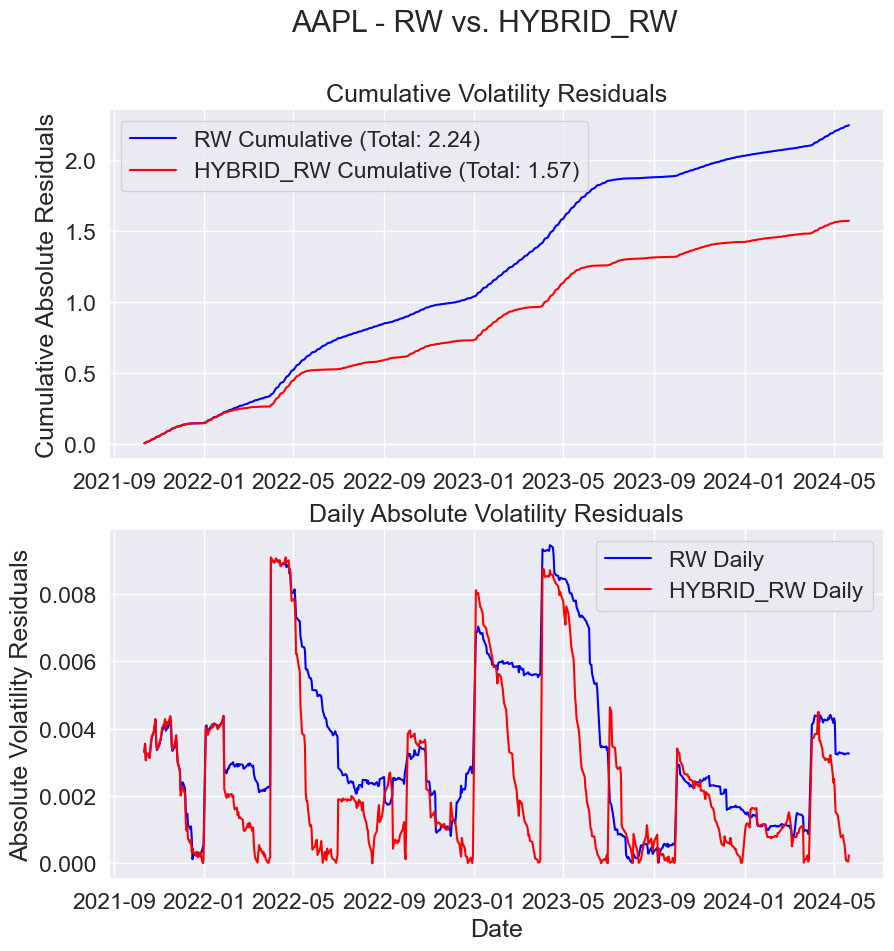

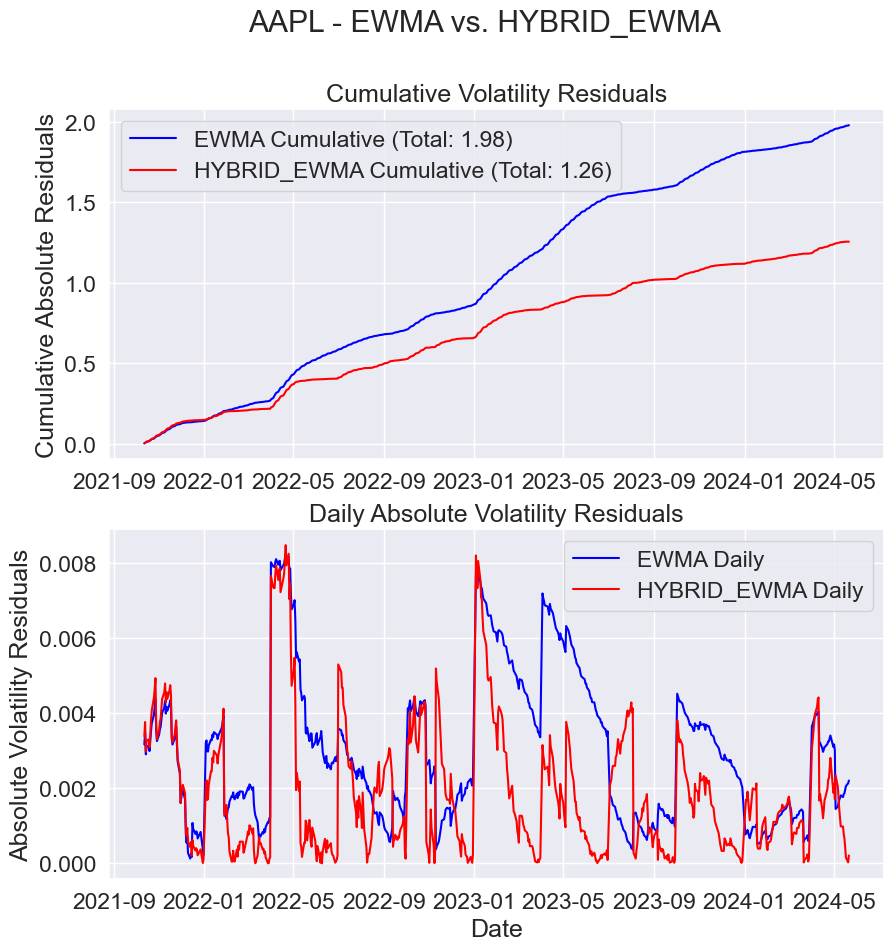

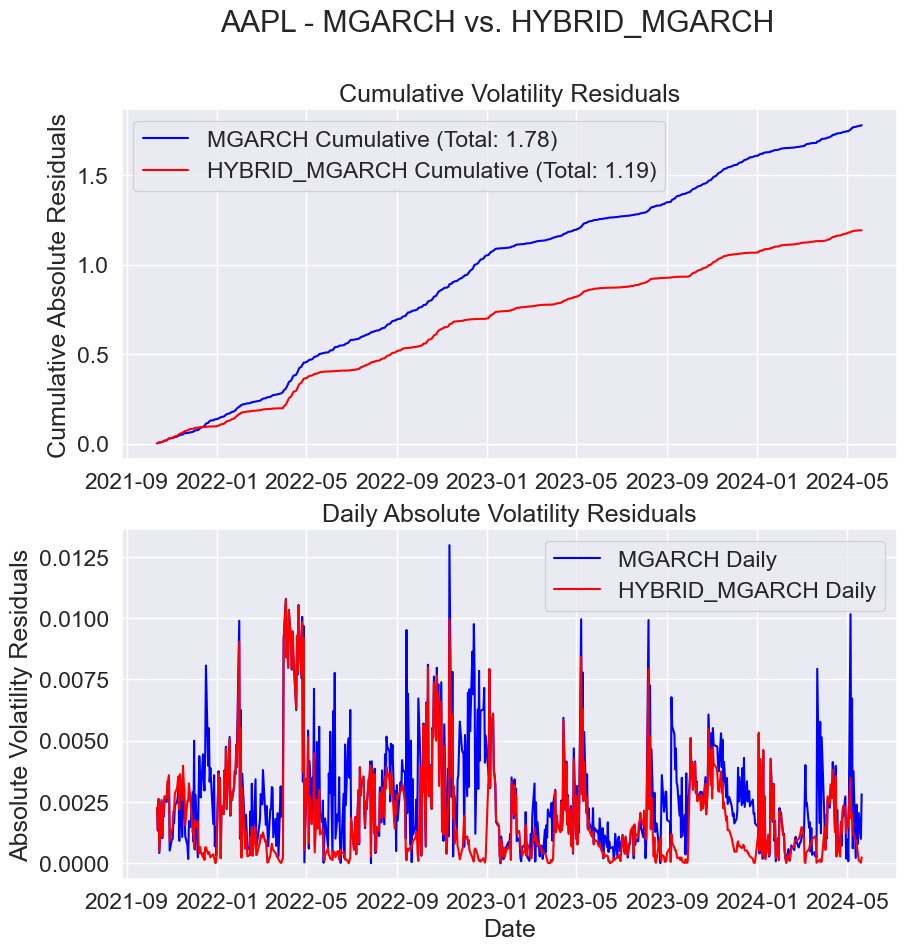

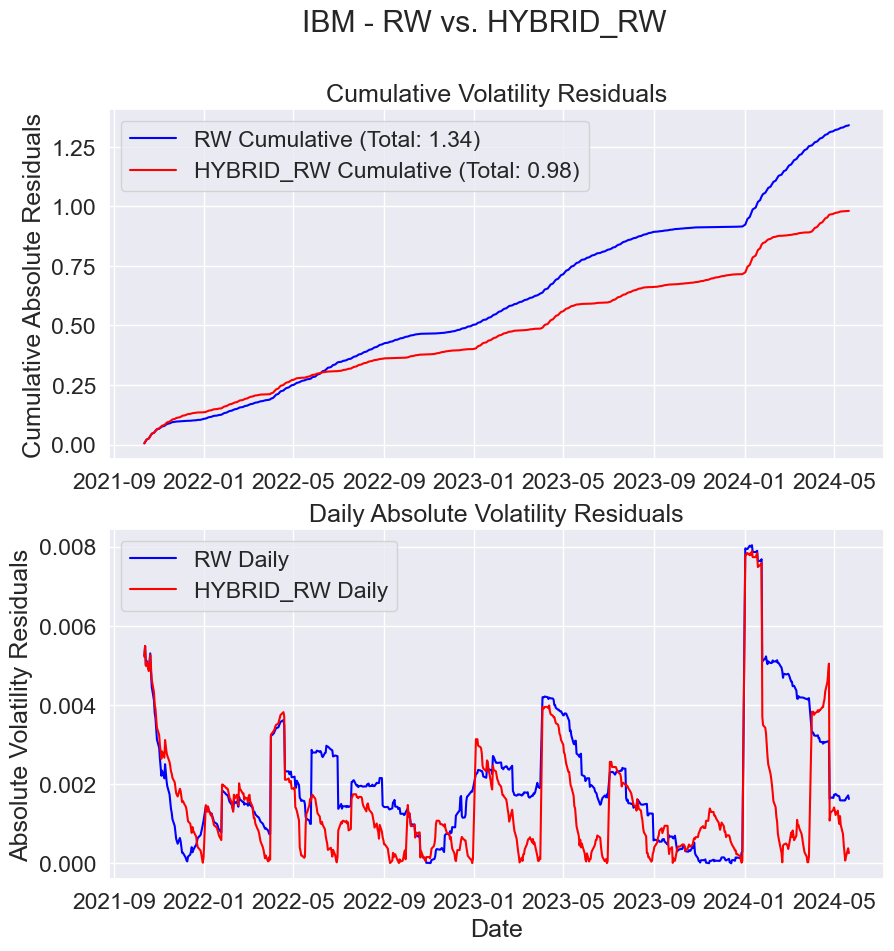

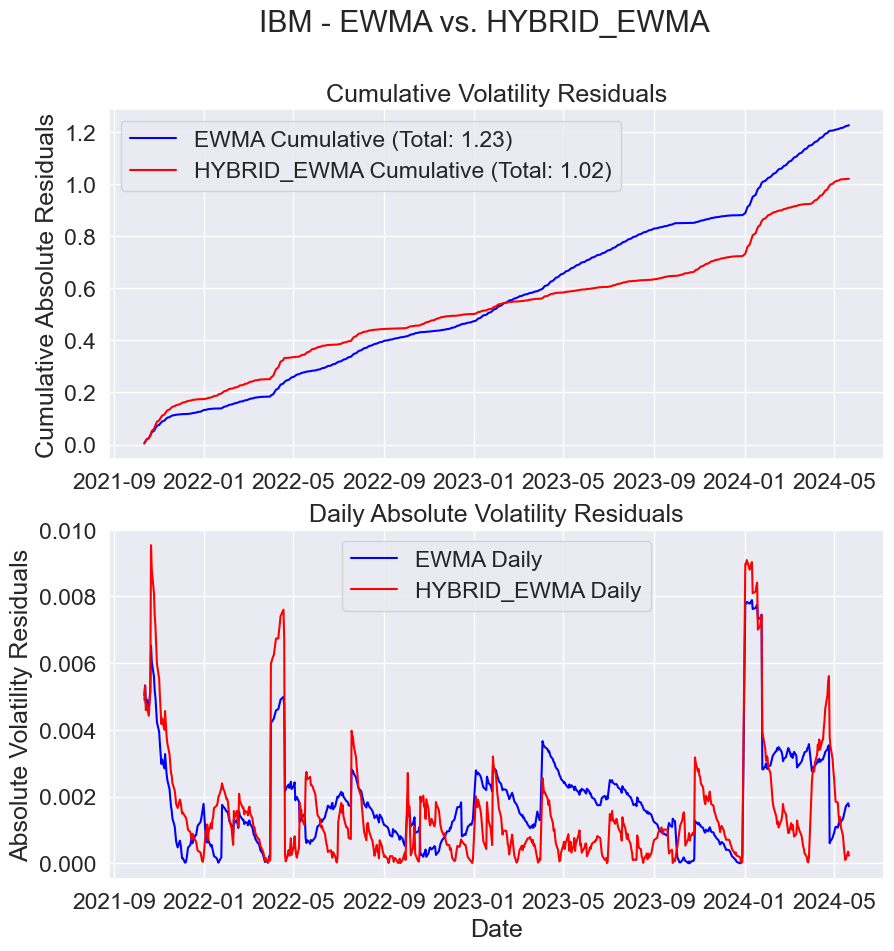

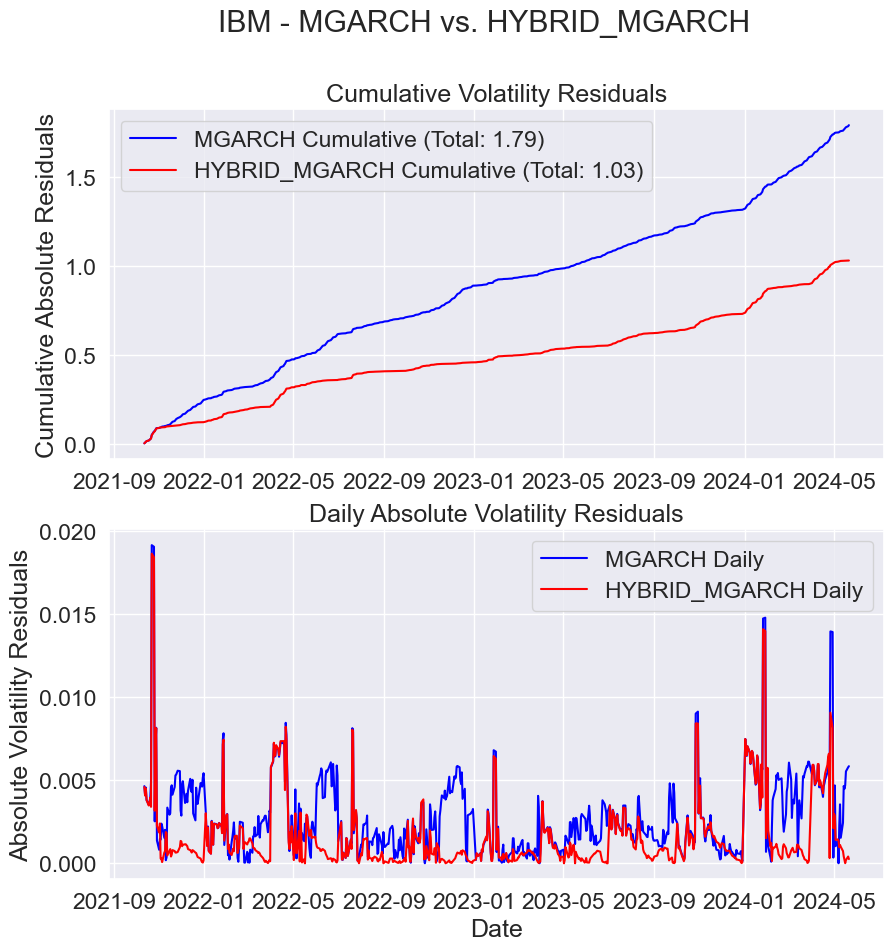

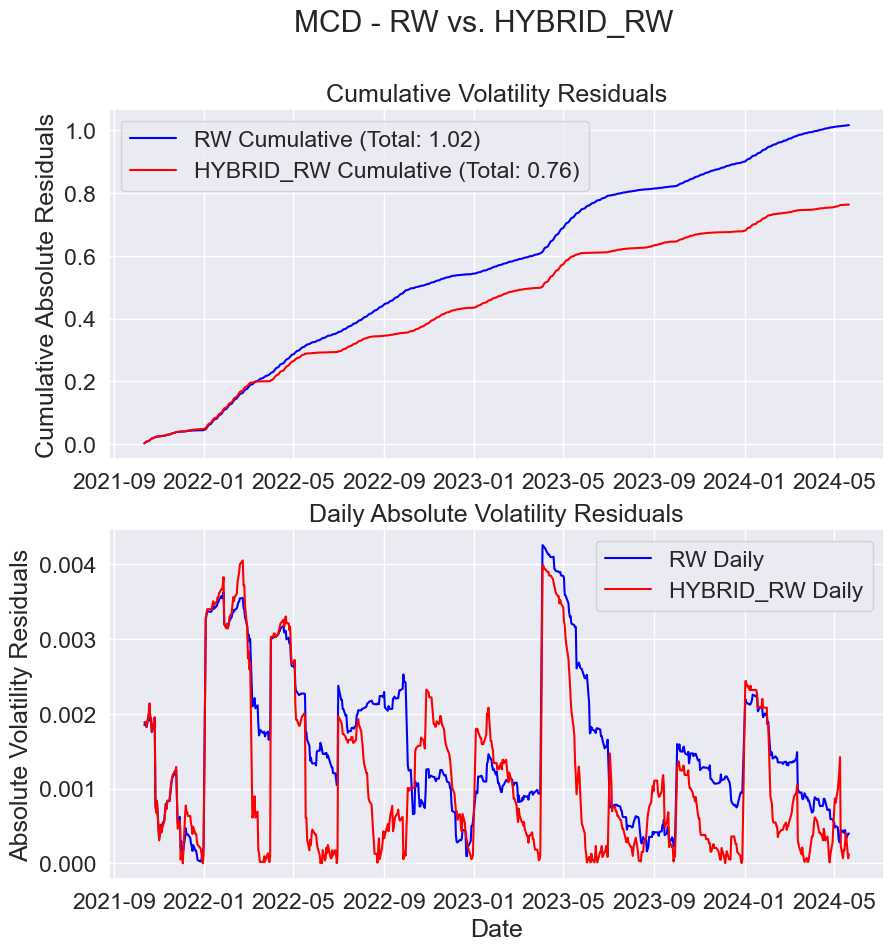

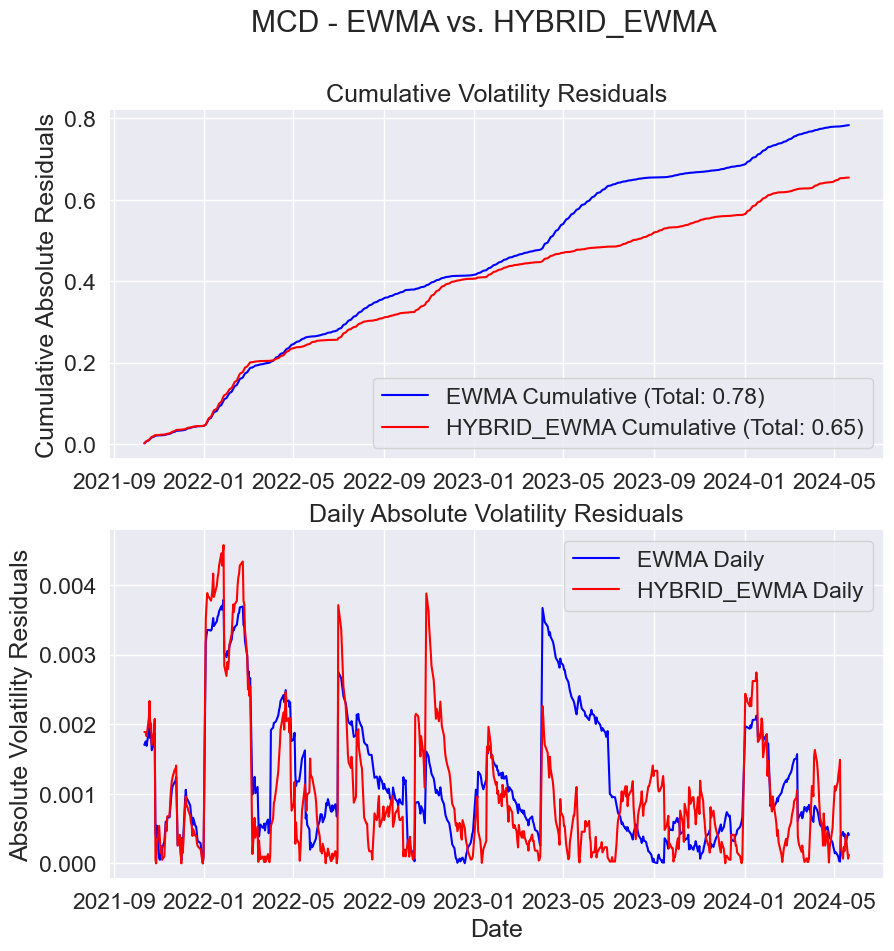

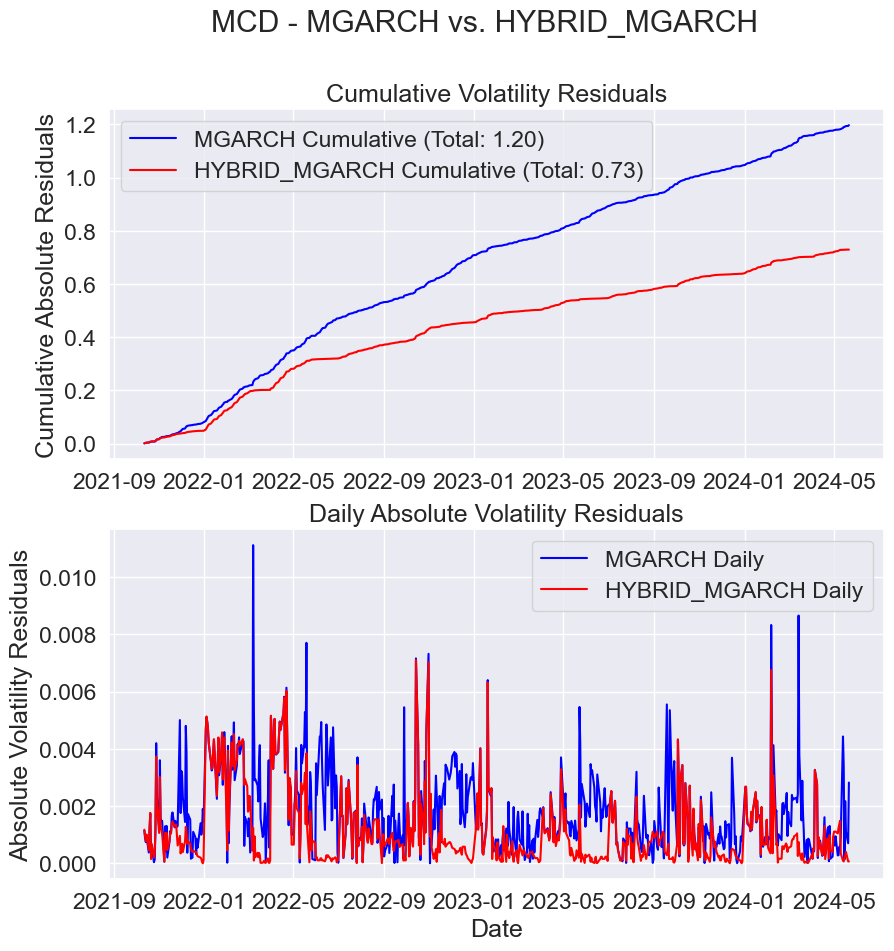

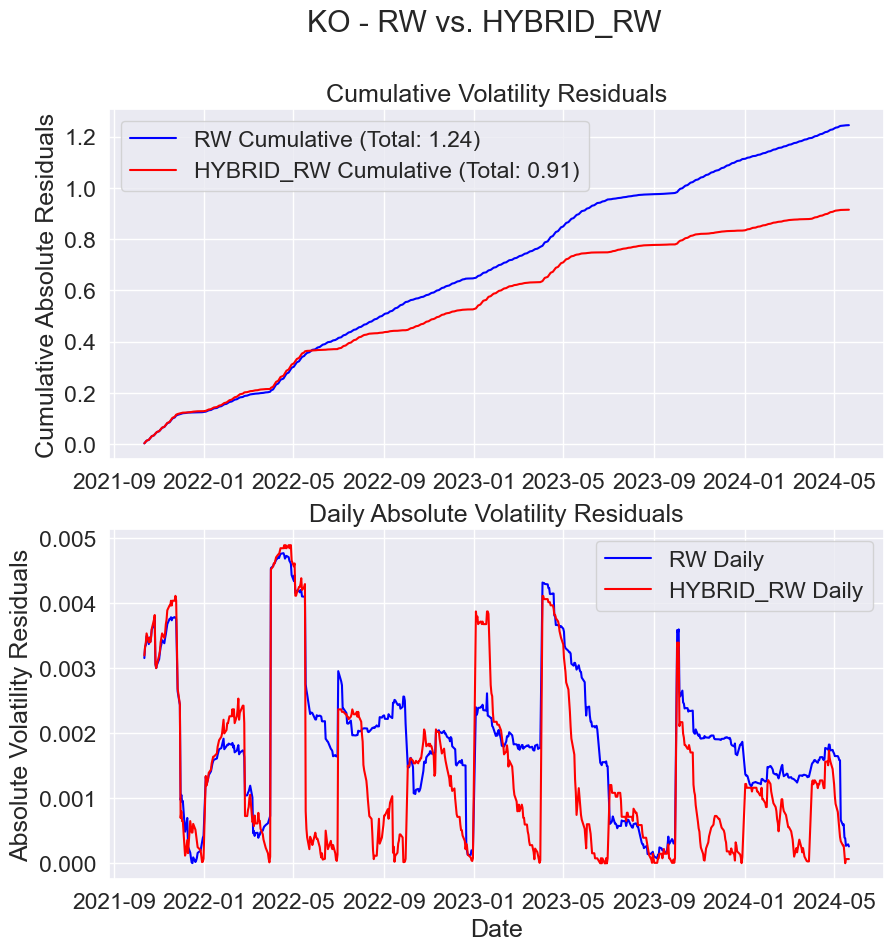

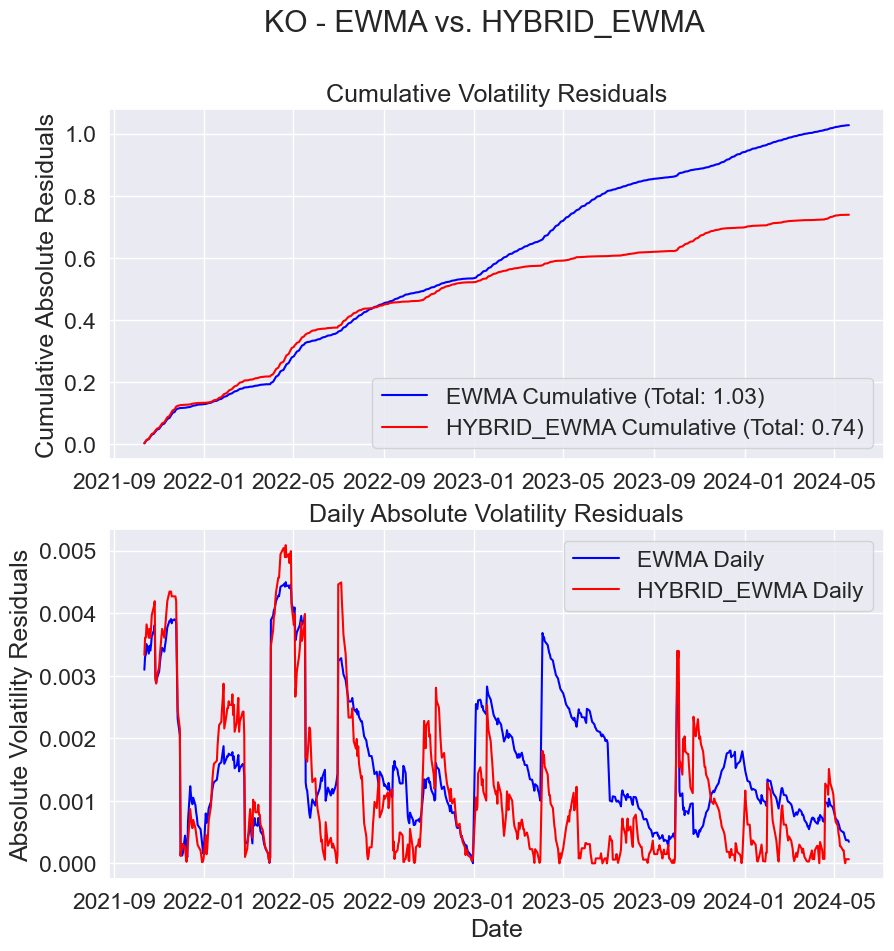

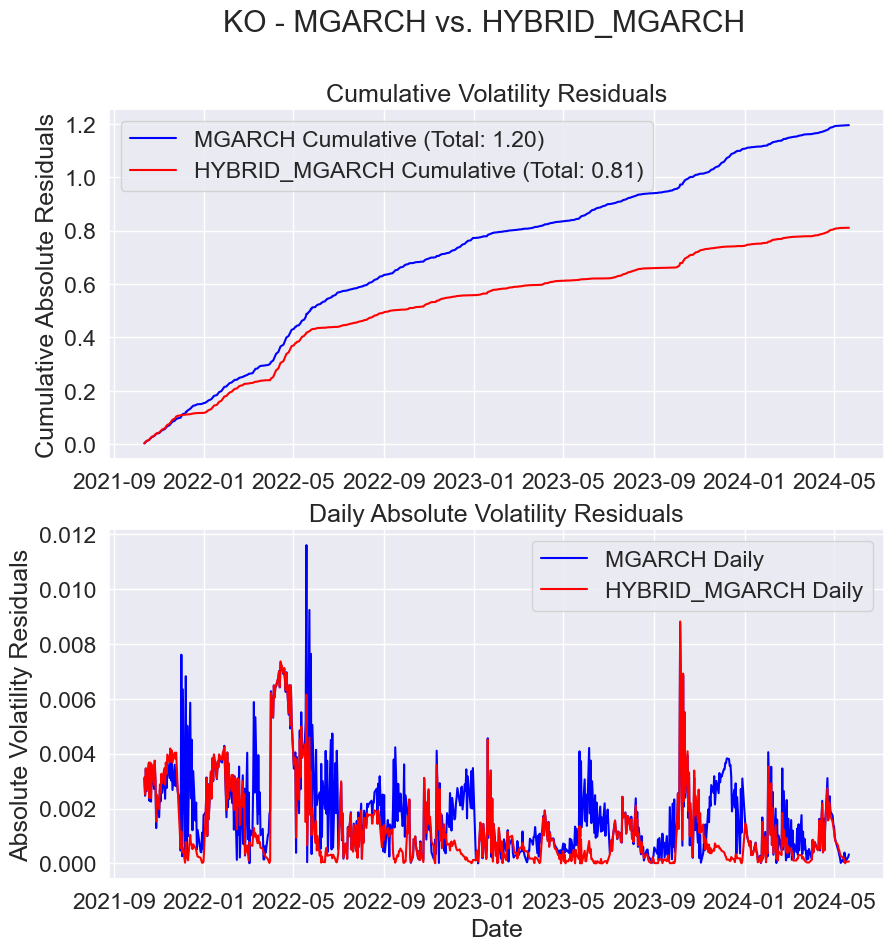

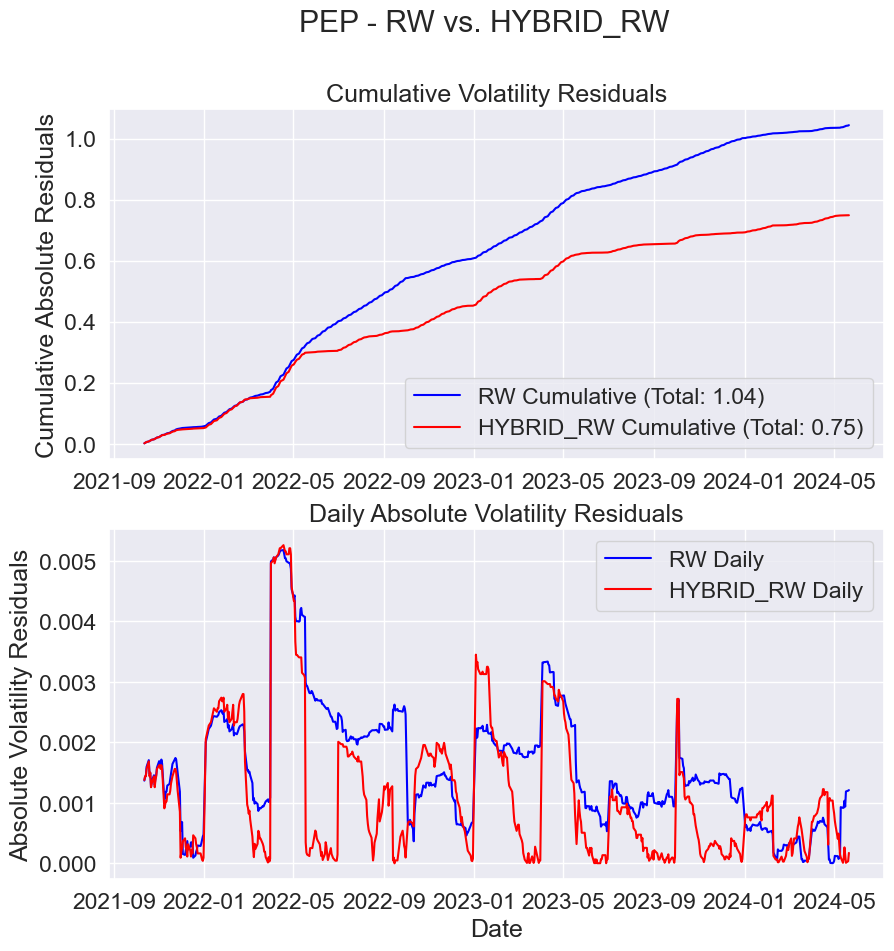

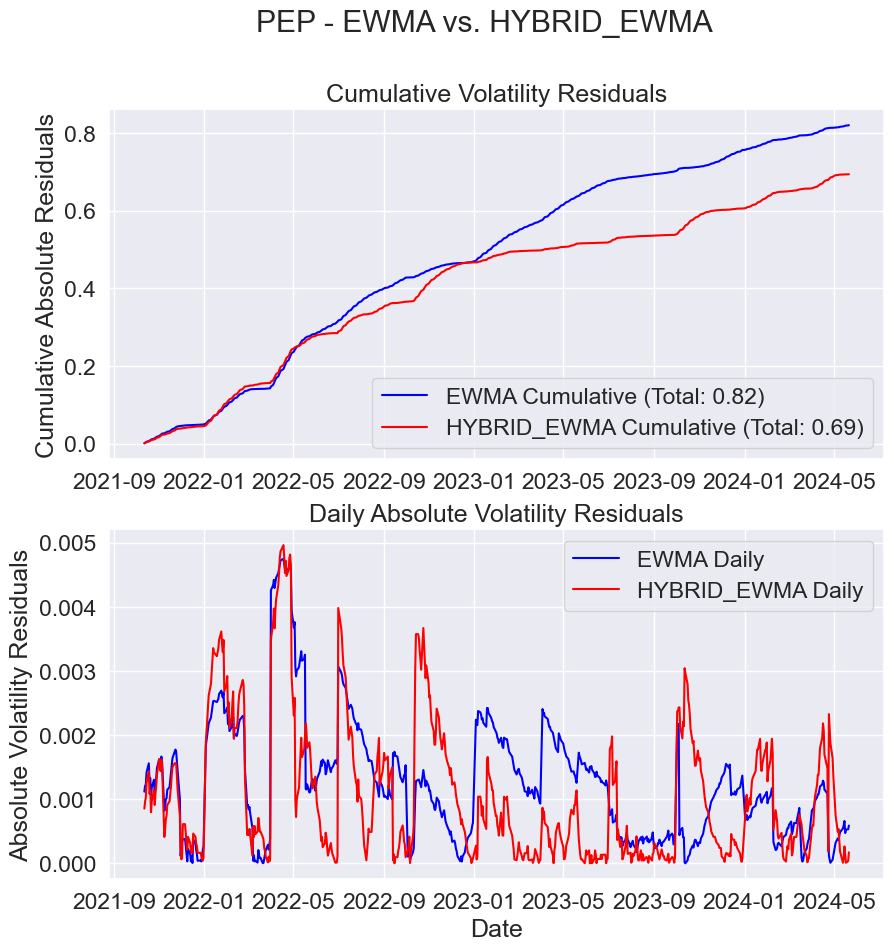

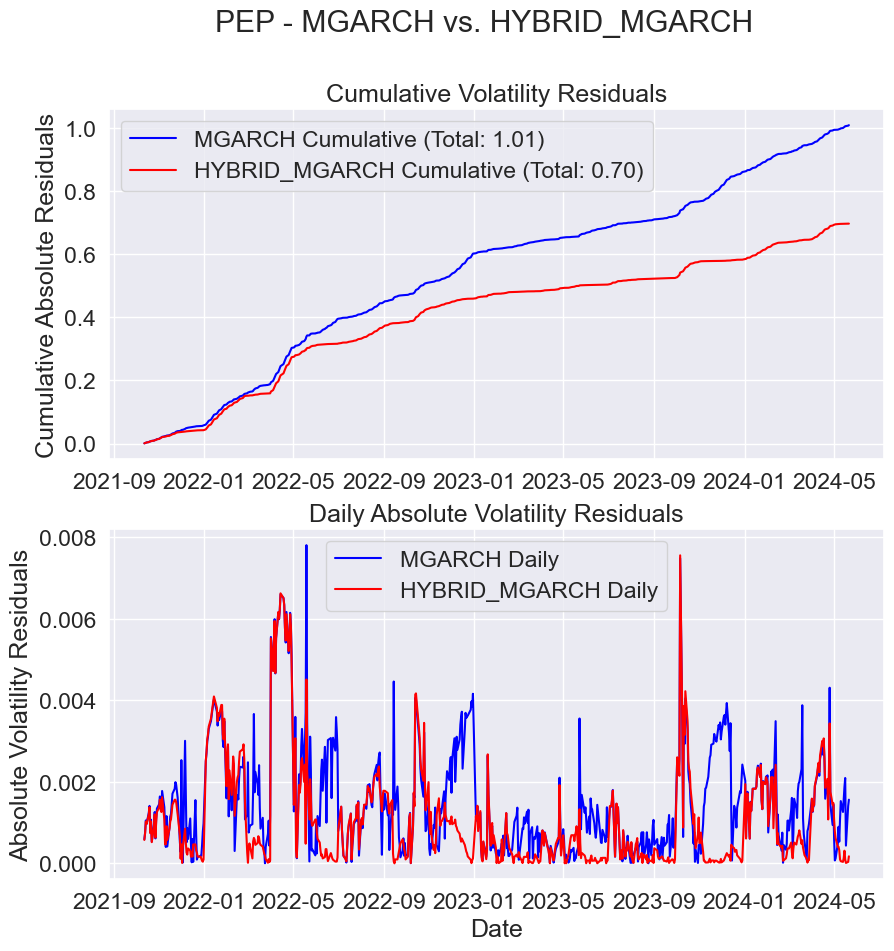

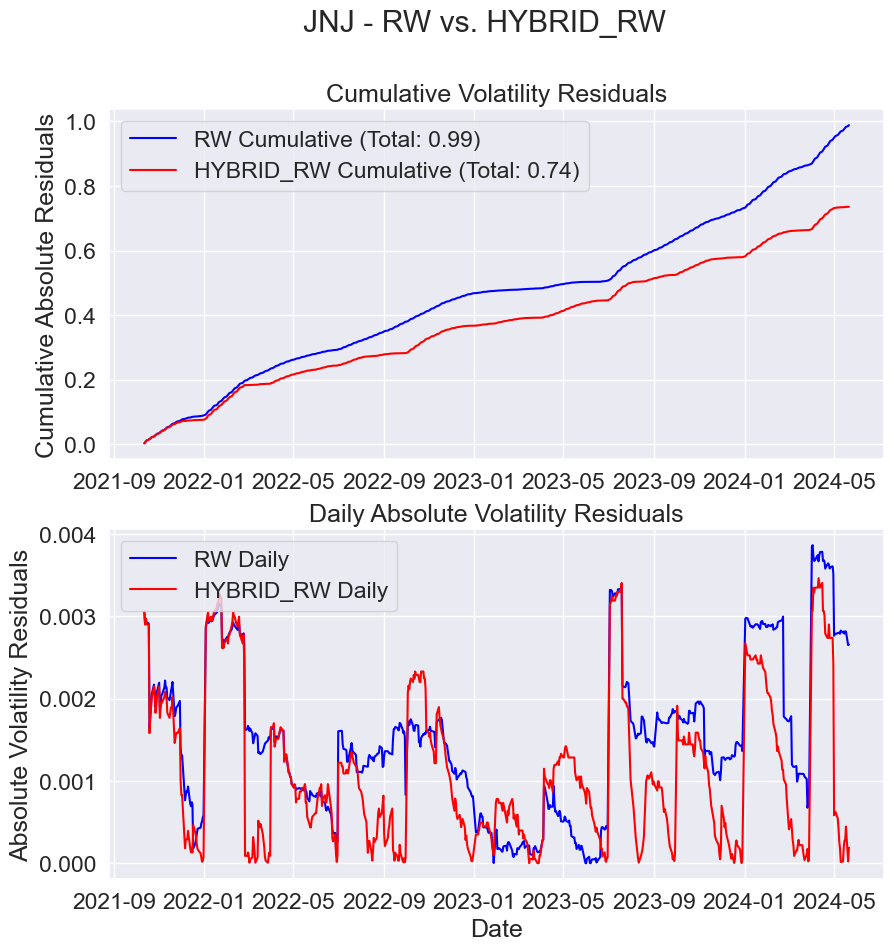

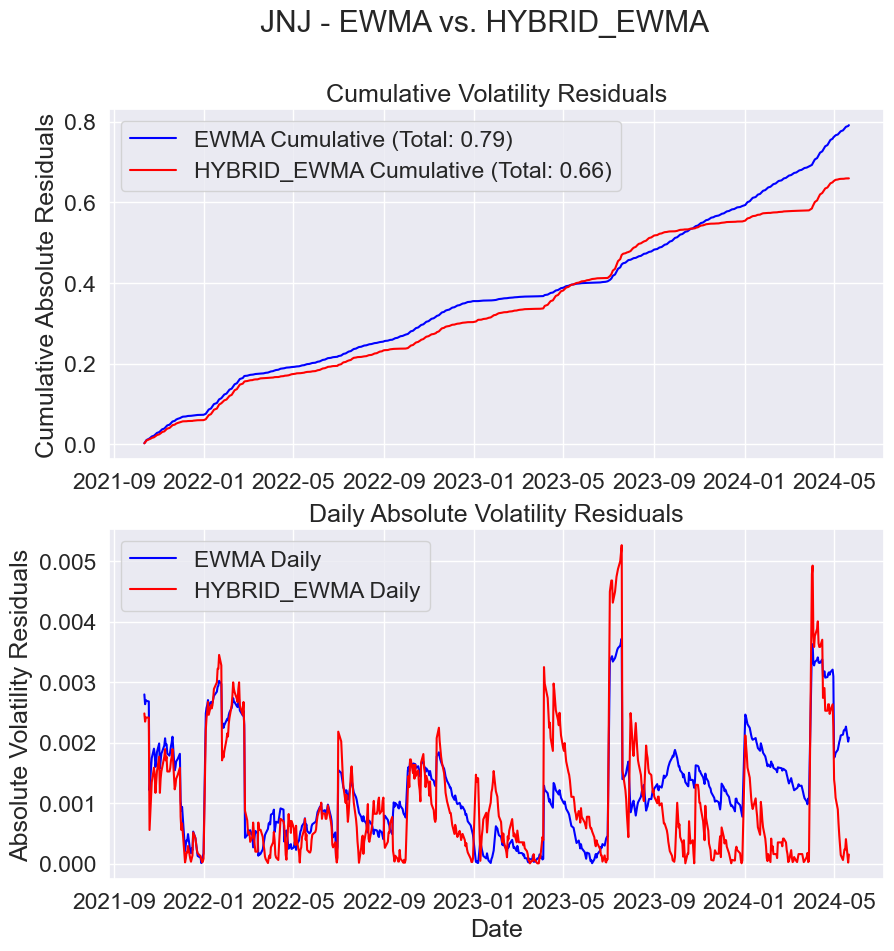

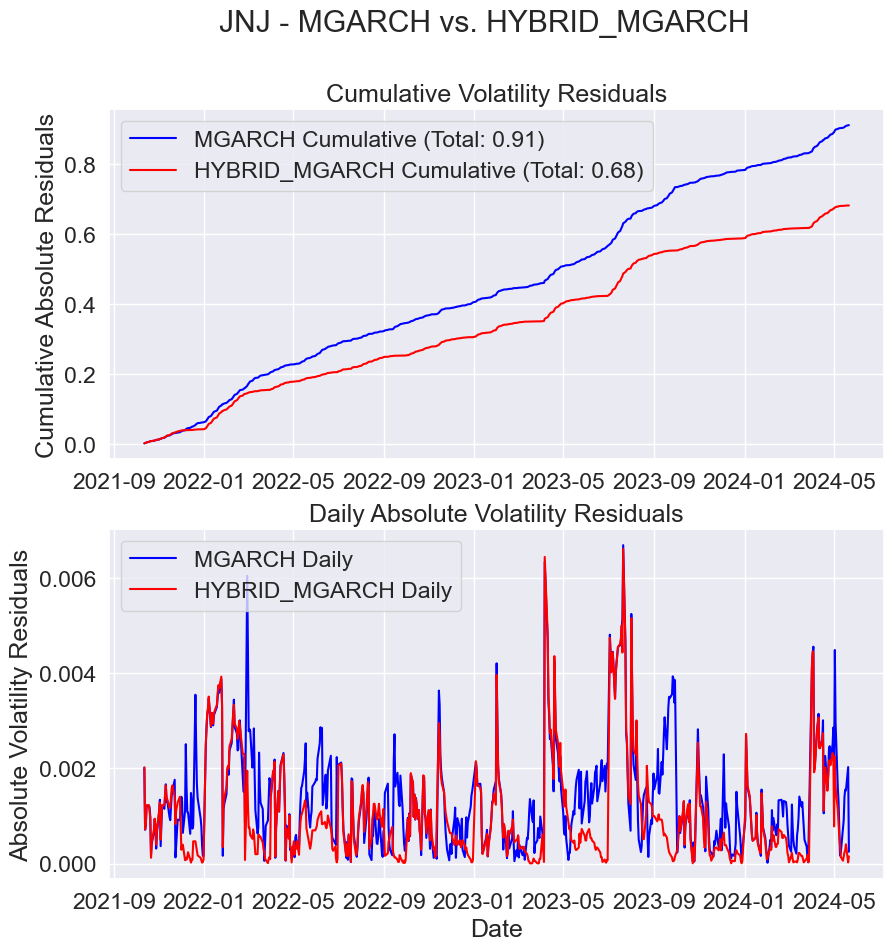

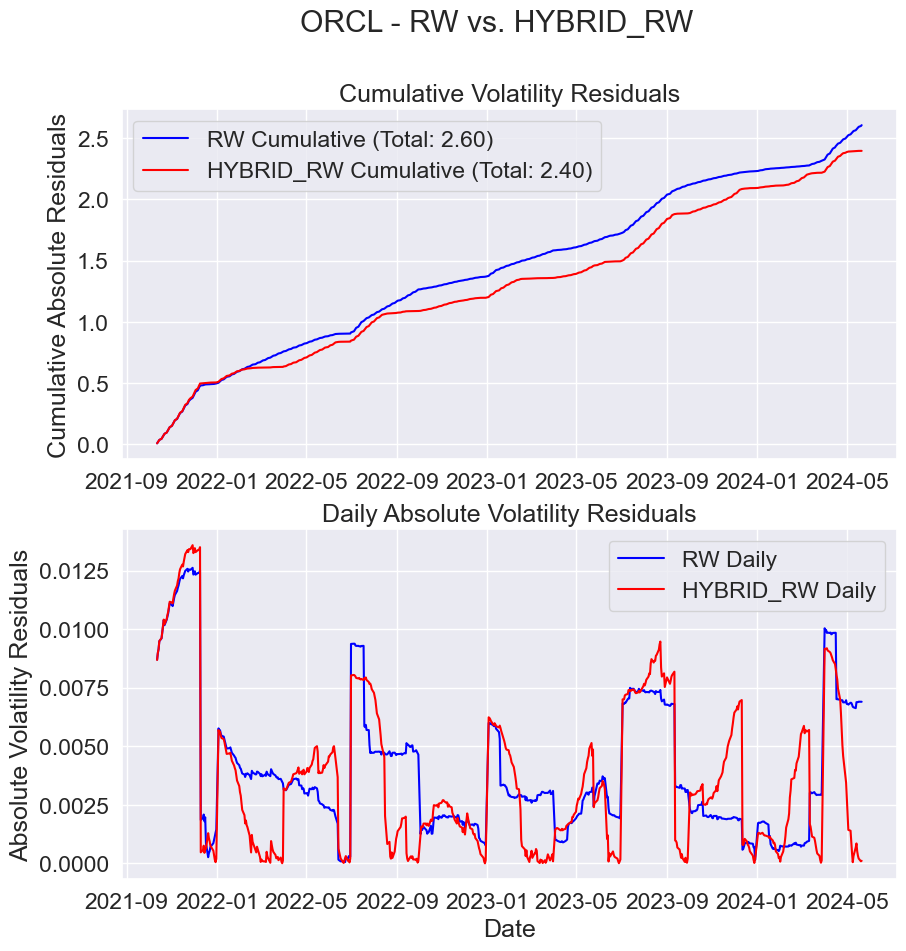

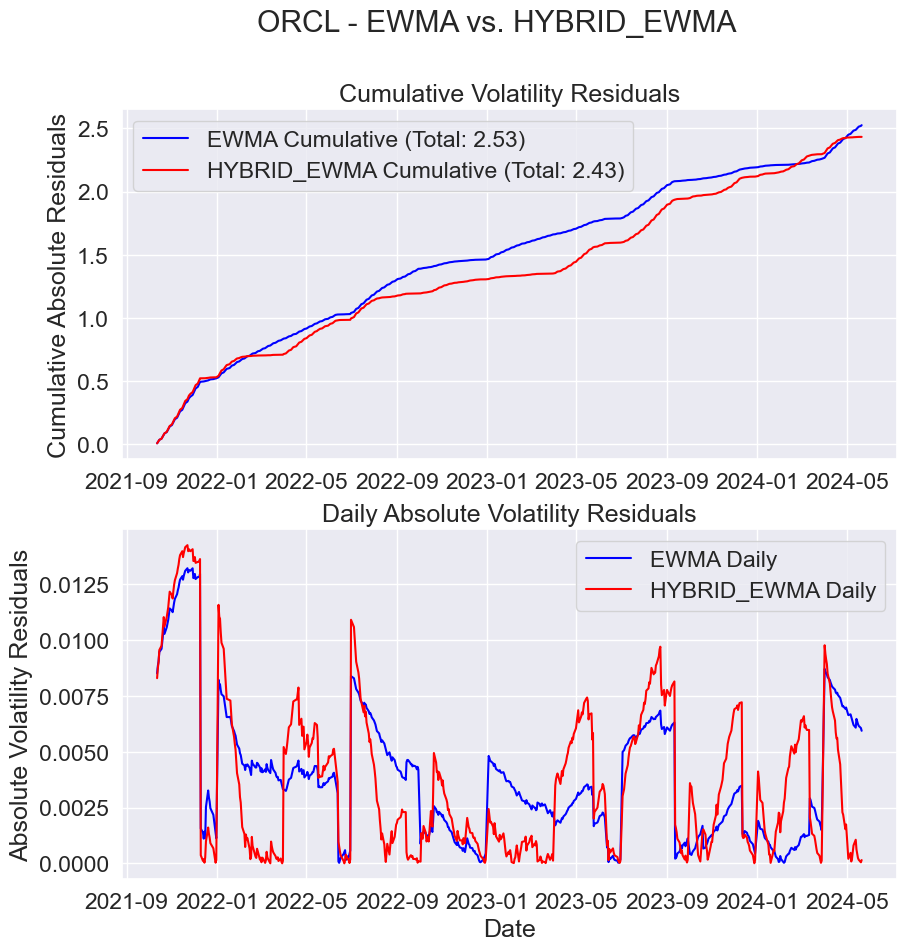

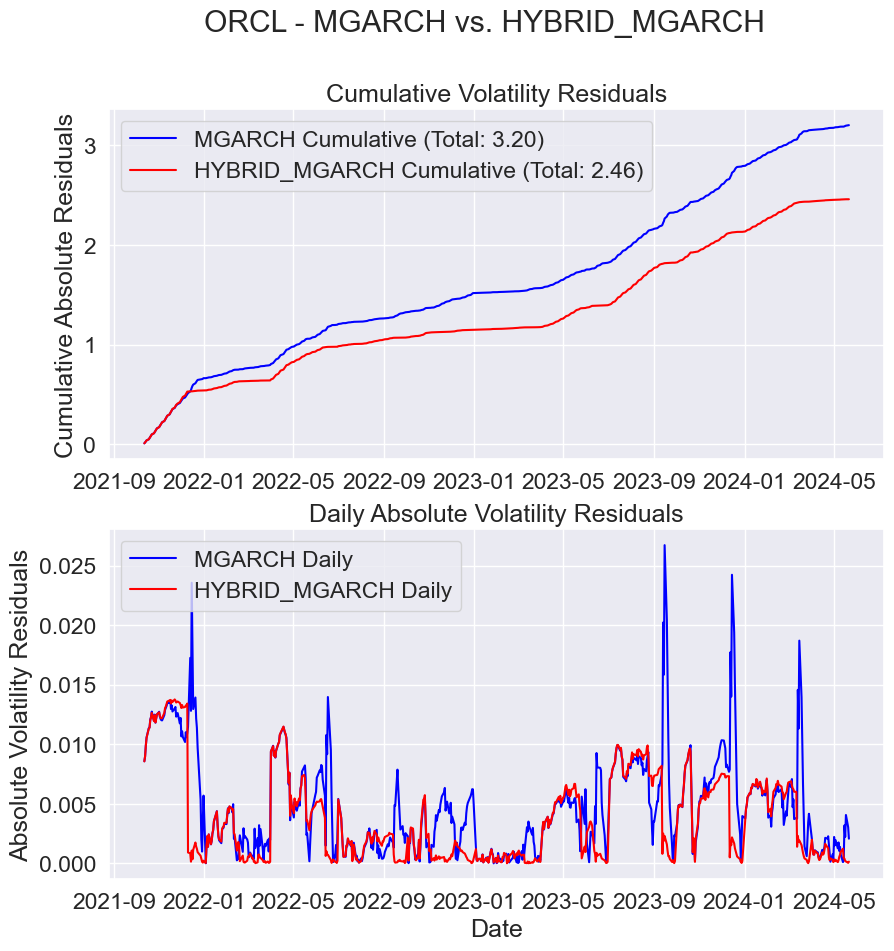

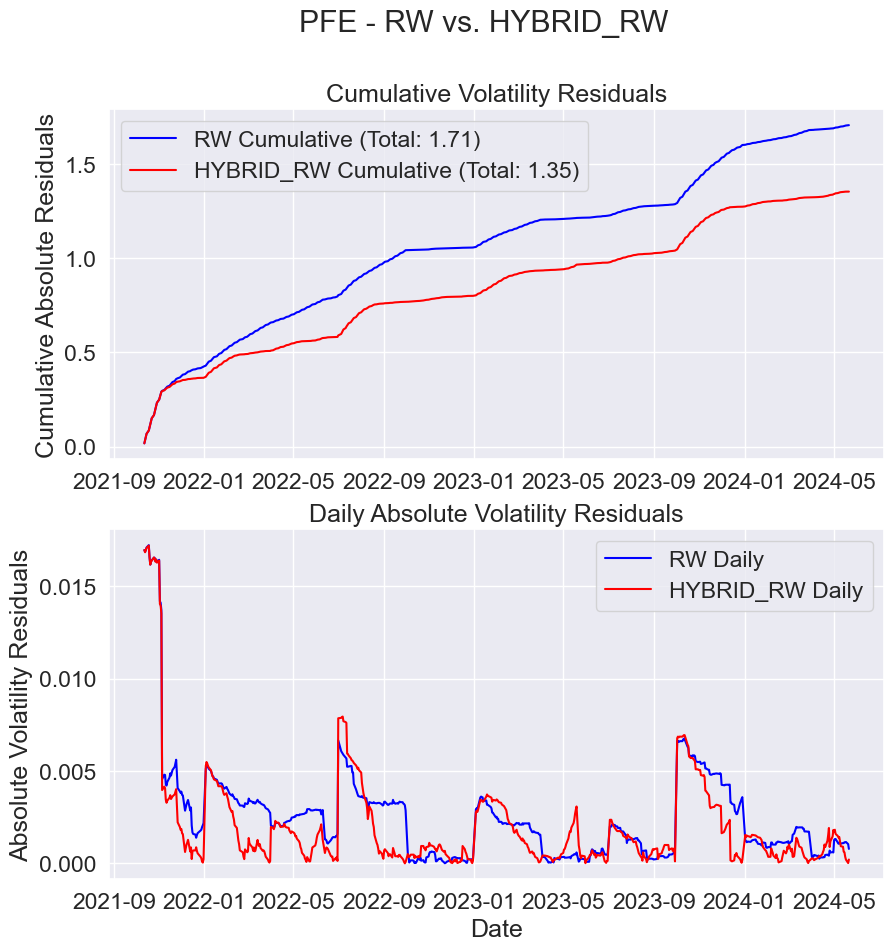

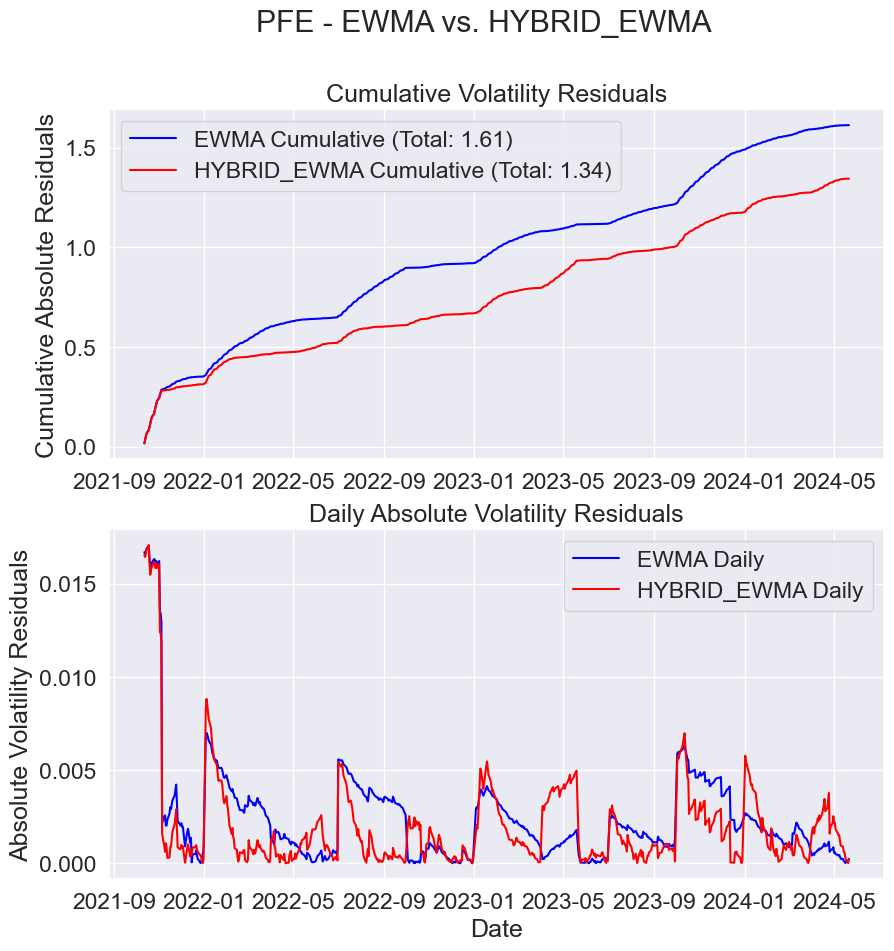

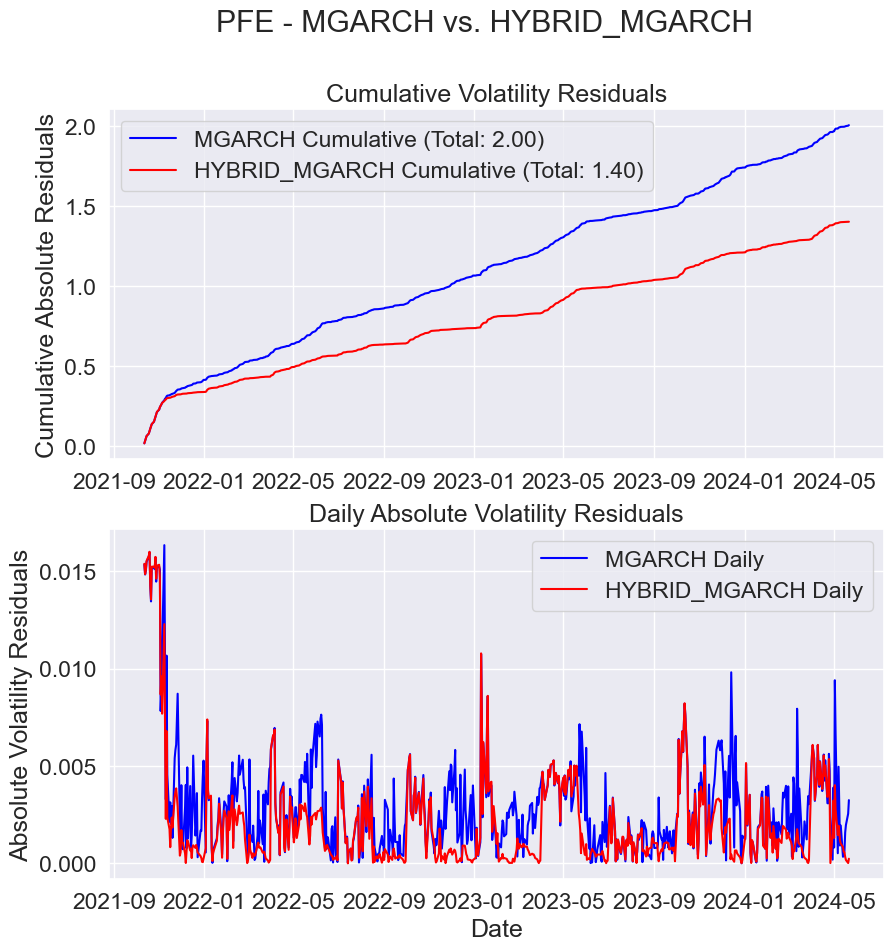

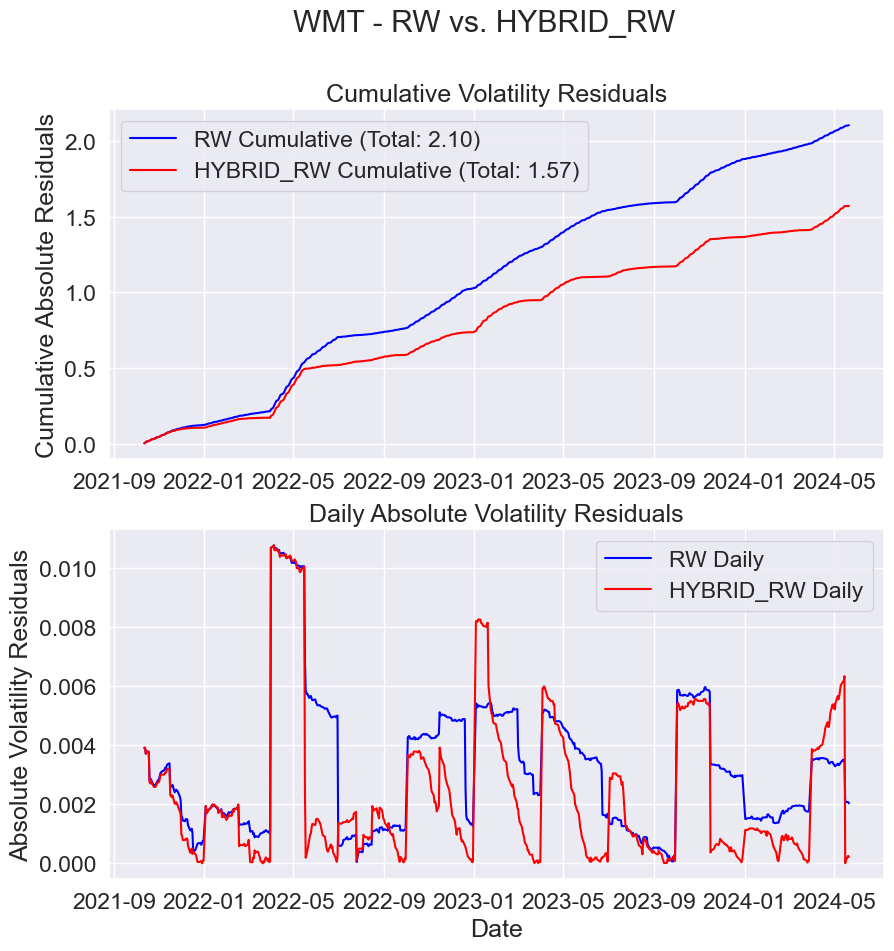

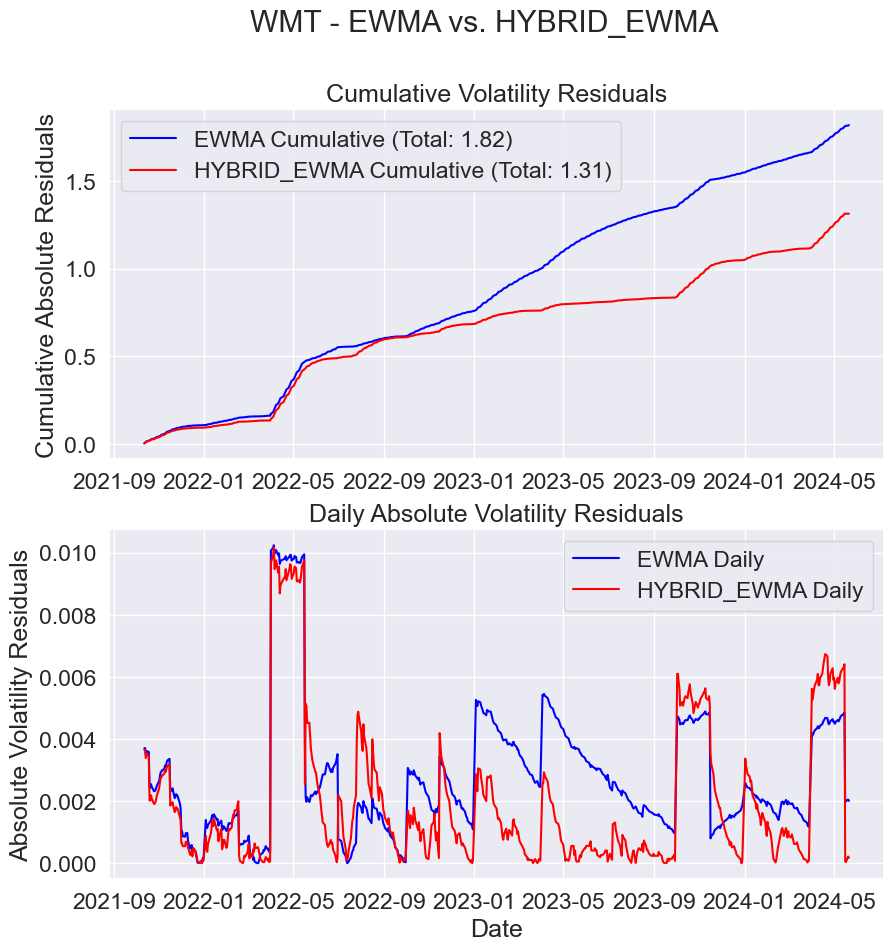

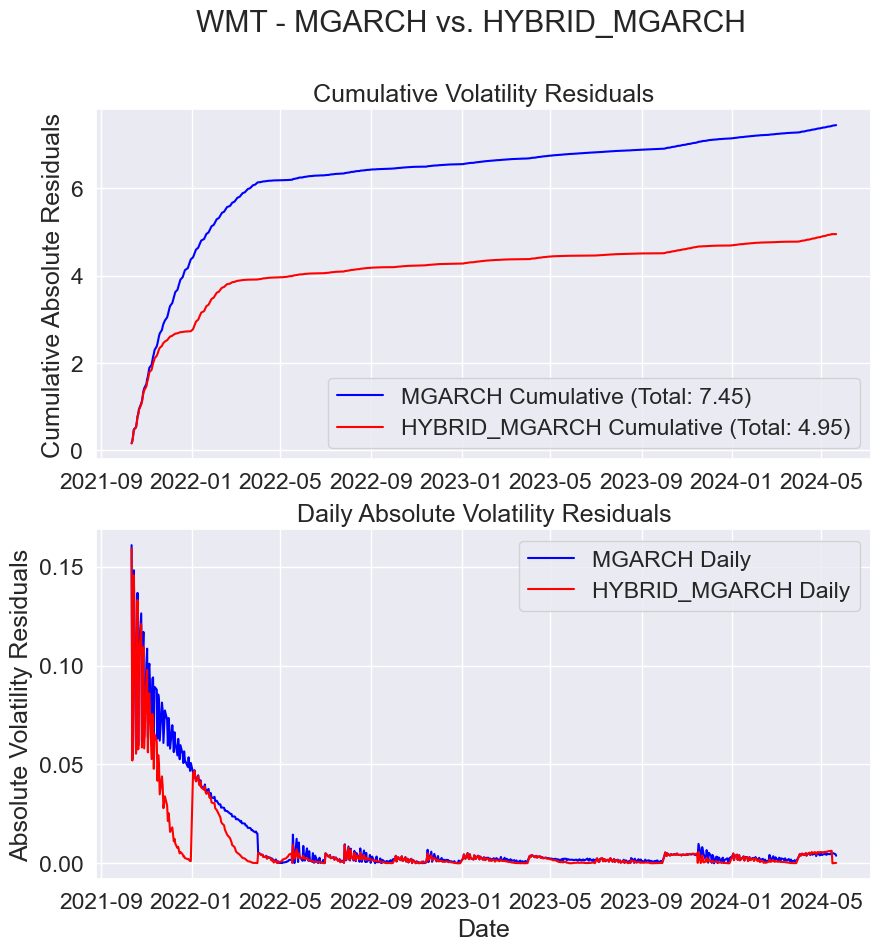

In [29]:
import pandas as pd
import matplotlib.pyplot as plt

# Min and max residuals values for normalization
MIN_RESIDUALS = 0
MAX_RESIDUALS = 0.160892  

# Dictionary for storing the data
volatilities = {
    'rw': rw_volatilities,
    'ewma': ewma_volatilities,
    'mgarch': mgarch_volatilities,
    'hybrid_rw': hybrid_rw_volatilities,
    'hybrid_ewma': hybrid_ewma_volatilities,
    'hybrid_mgarch': hybrid_mgarch_volatilities,
    'real': real_volatilities
}


# List of assets and predictors
assets = ['AAPL', 'IBM', 'MCD', 'KO', 'PEP', 'JNJ', 'ORCL', 'PFE', 'WMT']
predictors = ['rw', 'ewma', 'mgarch']
hybrids = ['hybrid_rw', 'hybrid_ewma', 'hybrid_mgarch']

# Function to calculate and truncate residuals
def calculate_residuals(real_vol, pred_vol):
    residuals = {date: real_vol[date] - pred_vol[date] for date in real_vol}
    # Truncate residuals to 6 decimal places
    truncated_residuals = {date: round(value, 6) for date, value in residuals.items()}

    # make the absolute of every single value of residuals
    for date in truncated_residuals:
        truncated_residuals[date] = abs(truncated_residuals[date])

    normalizedResiduals = {}
    # Normalize residuals
    for date in truncated_residuals:
        normalizedResiduals[date] = (truncated_residuals[date] - MIN_RESIDUALS) / (MAX_RESIDUALS - MIN_RESIDUALS)

    return truncated_residuals

# Function to find the maximum residual
def find_max_residual(residuals):
    max_val = 0
    for asset in residuals:
        for model in residuals[asset]:
            max_val = max(max_val, pd.Series(residuals[asset][model]).abs().max())
    return max_val

# Function to plot the residuals
def plot_residuals(asset, predictor, hybrid, residuals, start_date, end_date):
    # Prepare data
    abs_pred = pd.Series(residuals[predictor])
    abs_hybrid = pd.Series(residuals[hybrid])

    # Calculate cumulative sums
    cumsum_pred = abs_pred.cumsum()
    cumsum_hybrid = abs_hybrid.cumsum()

    # Plot settings
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))
    fig.suptitle(f'{asset} - {predictor.upper()} vs. {hybrid.upper()}')

    # Cumulative Residuals
    ax1.plot(cumsum_pred, label=f'{predictor.upper()} Cumulative (Total: {cumsum_pred.iloc[-1]:.2f})', color='blue')
    ax1.plot(cumsum_hybrid, label=f'{hybrid.upper()} Cumulative (Total: {cumsum_hybrid.iloc[-1]:.2f})', color='red')
    ax1.set_title('Cumulative Volatility Residuals')
    ax1.legend()
    ax1.set_ylabel('Cumulative Absolute Residuals')
    ax1.grid(True)

    # Daily Residuals
    ax2.plot(abs_pred, label=f'{predictor.upper()} Daily', color='blue')
    ax2.plot(abs_hybrid, label=f'{hybrid.upper()} Daily', color='red')
    ax2.set_title('Daily Absolute Volatility Residuals')
    ax2.legend()
    ax2.set_xlabel('Date')
    ax2.set_ylabel('Absolute Volatility Residuals')
    ax2.grid(True)

    plt.show()

# Calculate and plot residuals for each asset
residuals = {}
for asset in assets:
    residuals[asset] = {}
    real_vol = volatilities['real'][asset]

    for predictor in predictors:
        pred_vol = volatilities[predictor][asset]
        hybrid = 'hybrid_' + predictor
        hybrid_vol = volatilities[hybrid][asset]

        residuals[asset][predictor] = calculate_residuals(real_vol, pred_vol)
        residuals[asset][hybrid] = calculate_residuals(real_vol, hybrid_vol)

        # Saving residuals to CSV
        df_pred = pd.DataFrame(list(residuals[asset][predictor].items()), columns=['Date', f'Residuals_{predictor}'])
        df_pred.to_csv(f'{asset}_{predictor}_residuals.csv', index=False)
        df_hybrid = pd.DataFrame(list(residuals[asset][hybrid].items()), columns=['Date', f'Residuals_{hybrid}'])
        df_hybrid.to_csv(f'{asset}_{hybrid}_residuals.csv', index=False)

    # First and last date for the plots
    start_date = min(real_vol.keys())
    end_date = max(real_vol.keys())

    # Plotting
    for predictor in predictors:
        hybrid = 'hybrid_' + predictor
        plot_residuals(asset, predictor, hybrid, residuals[asset], start_date, end_date)

WORKING CODE

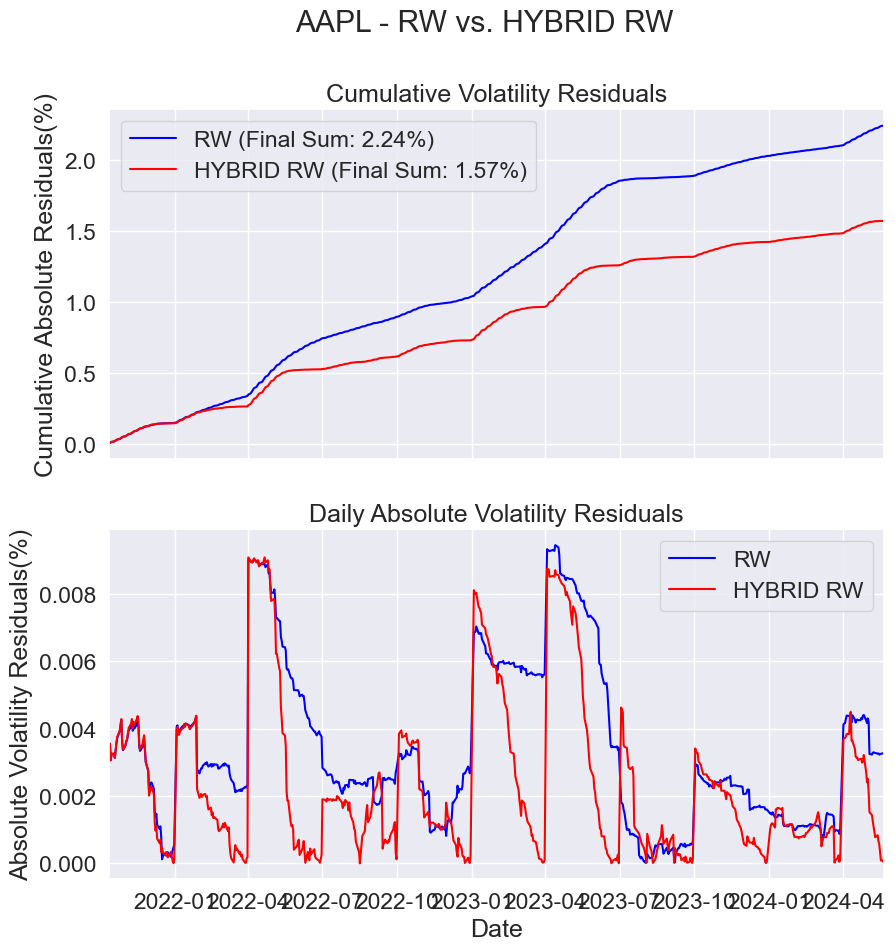

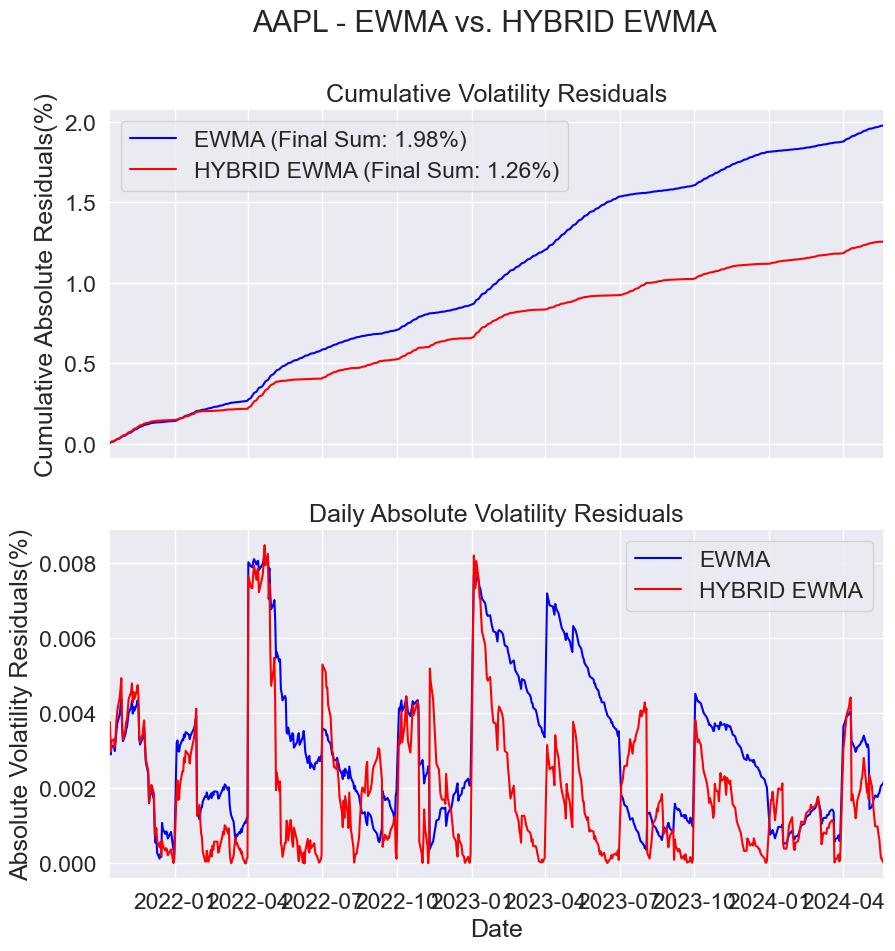

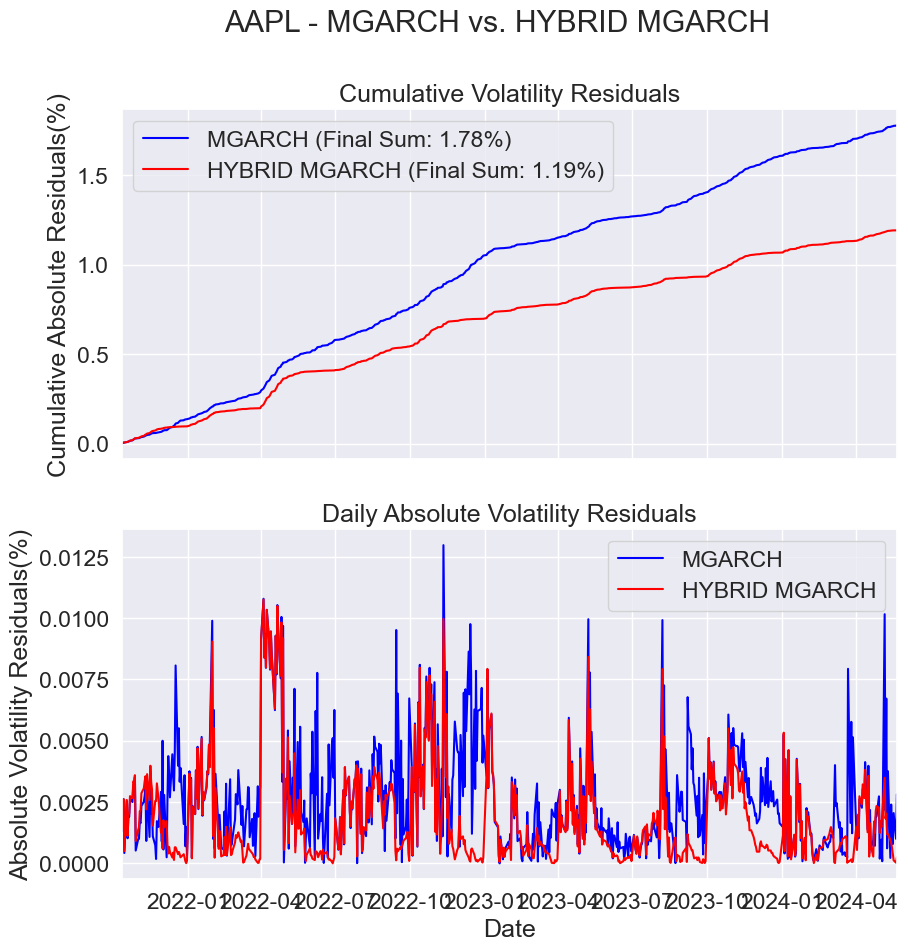

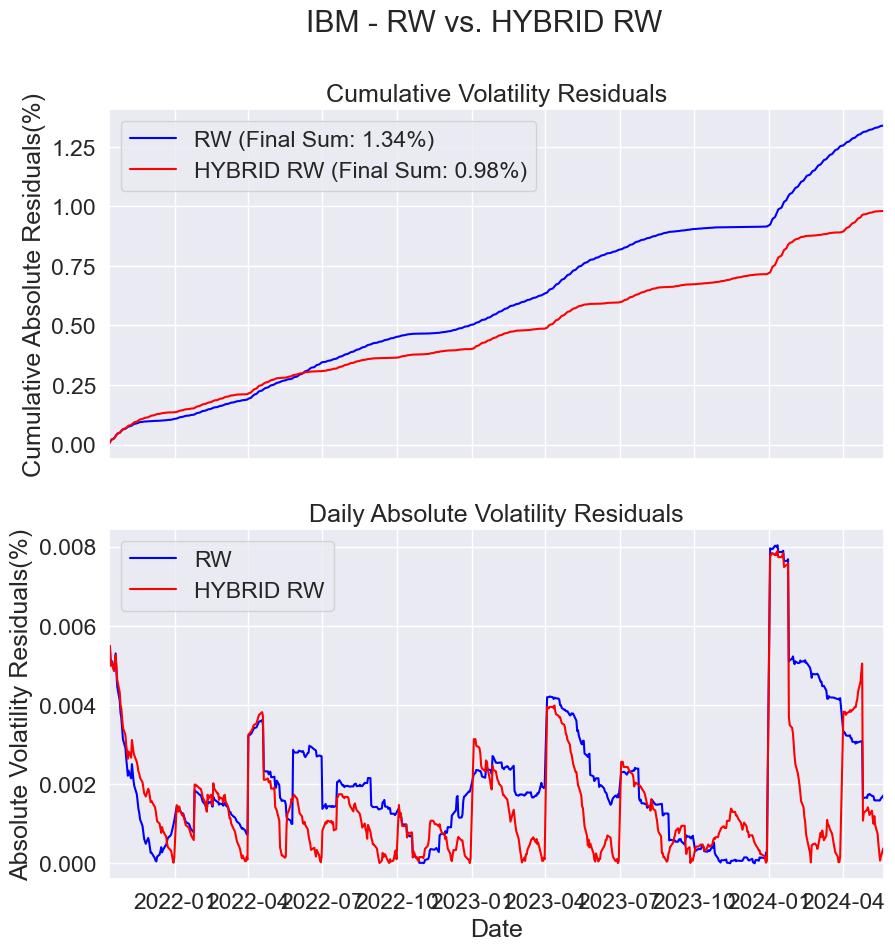

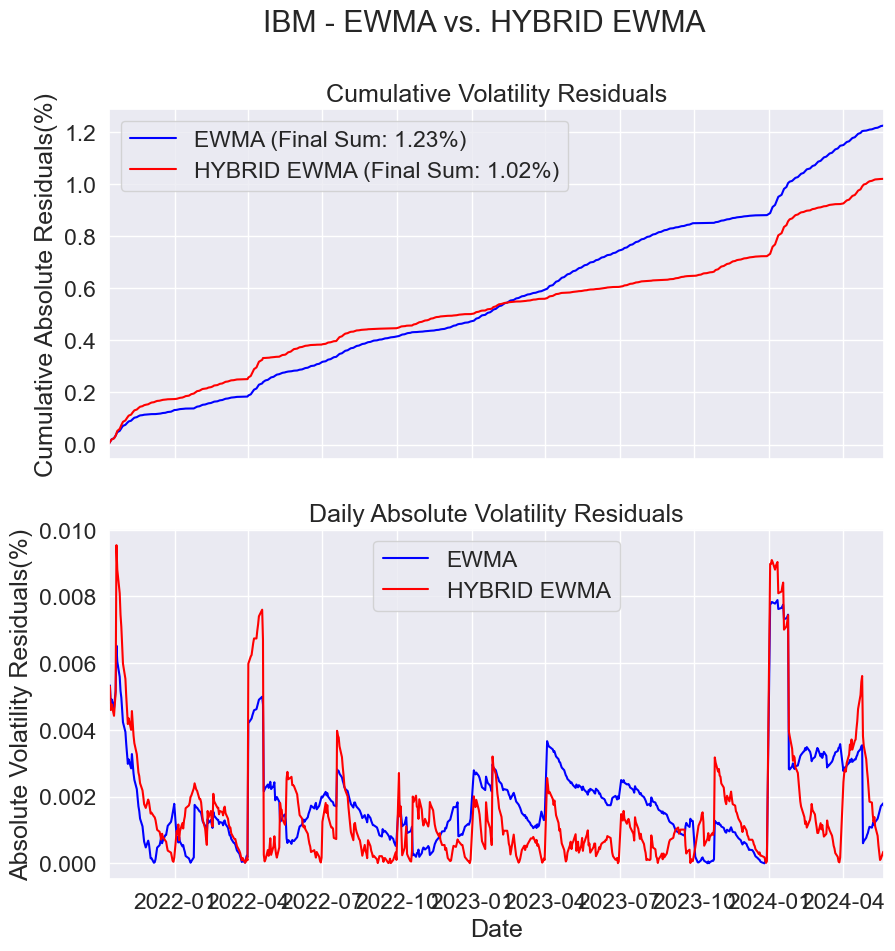

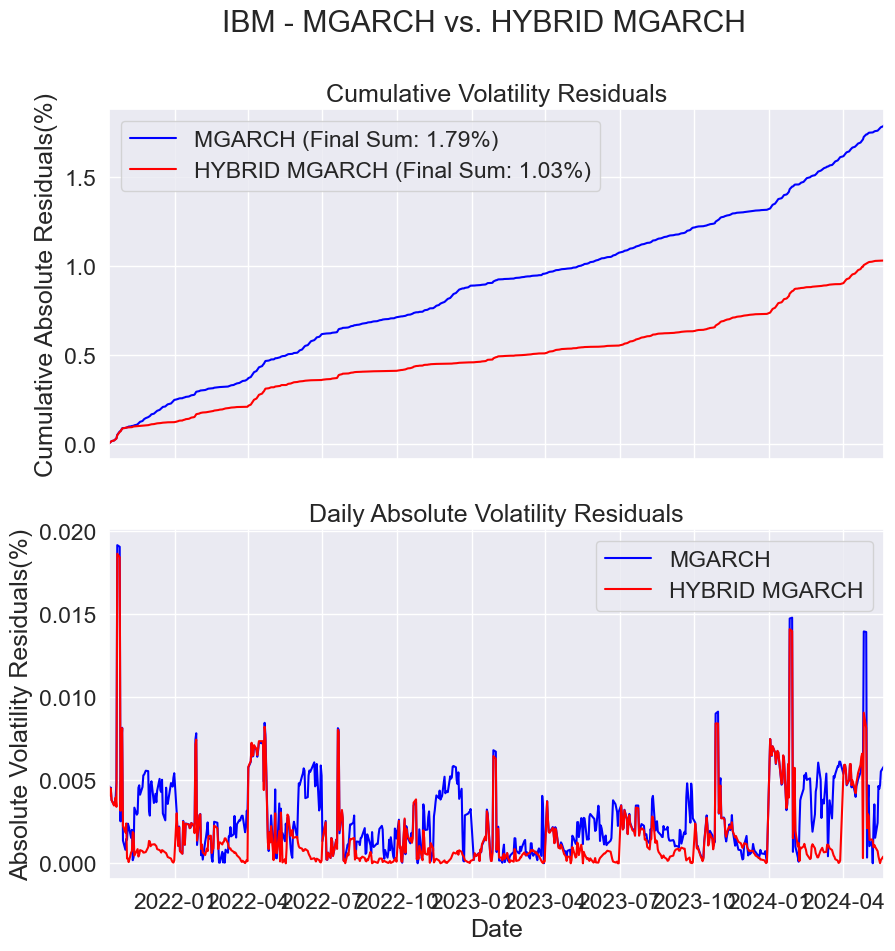

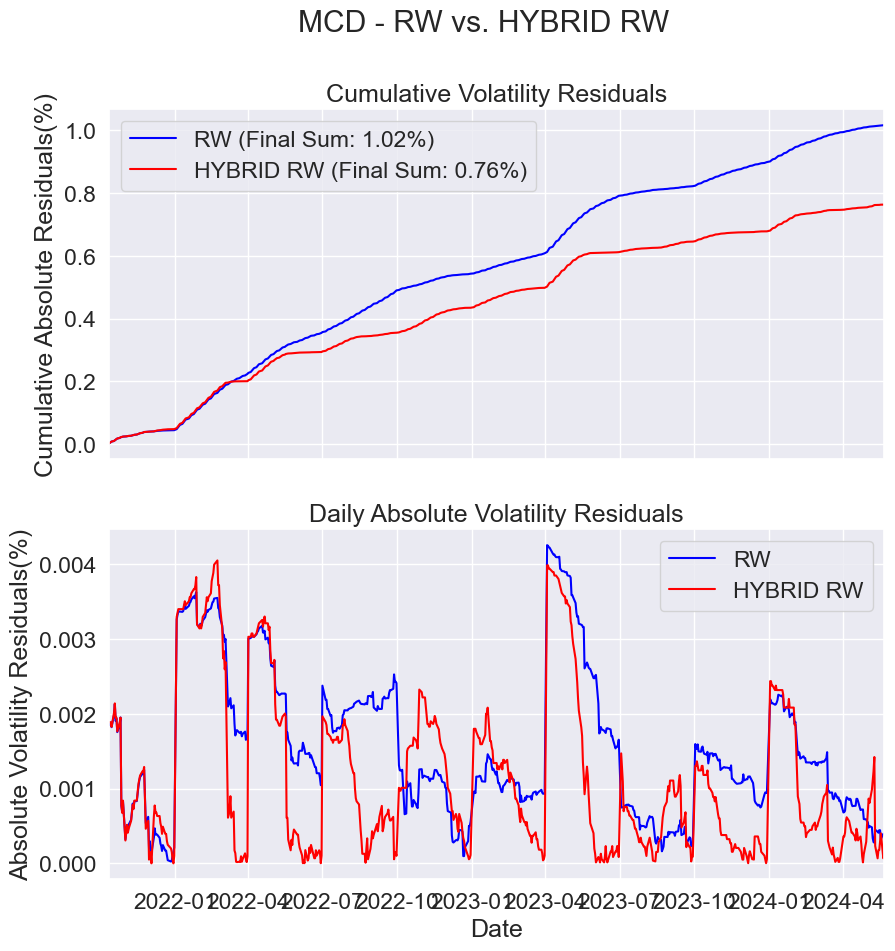

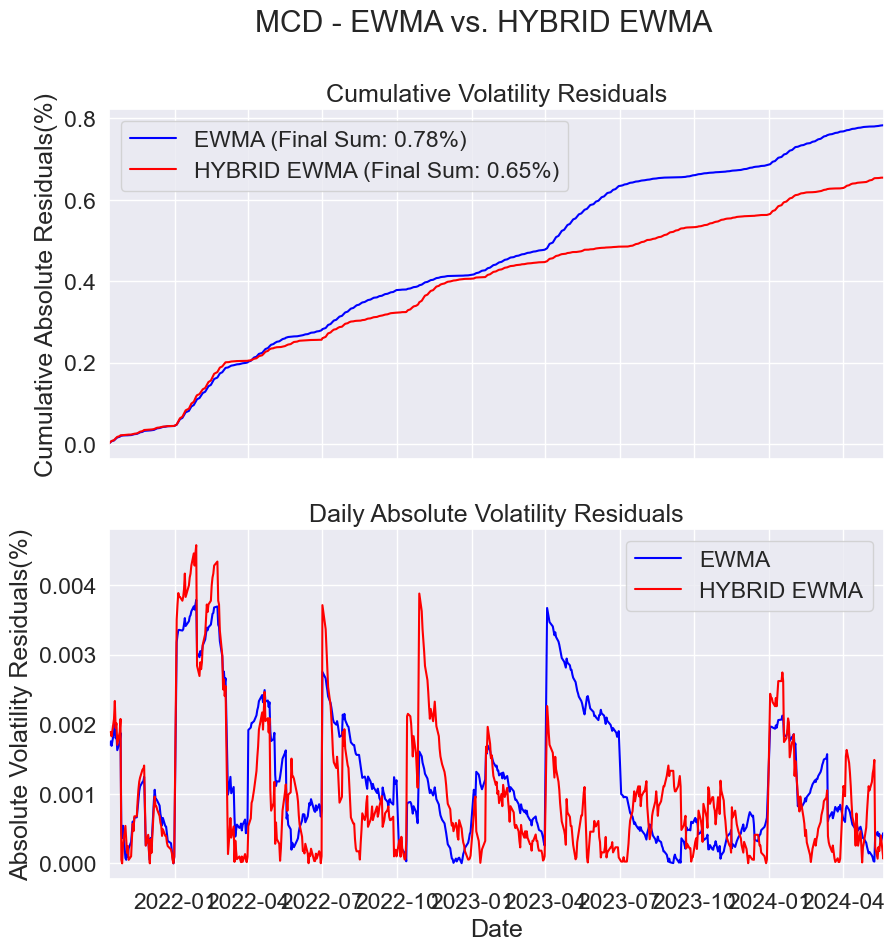

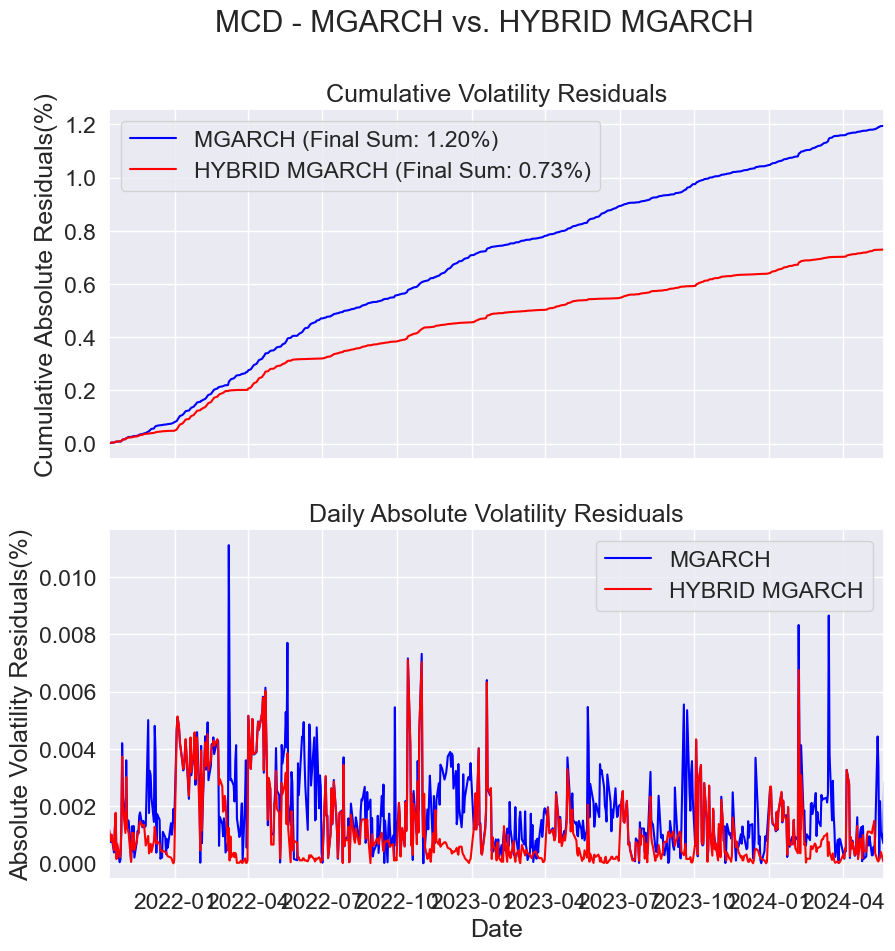

In [30]:
# calculate the volatility residual for every predictor and for every asset

# AAPL
# Calculate the residuals
rw_residuals_AAPL = {key: real_volatilities["AAPL"][key] - rw_volatilities["AAPL"][key] for key in rw_volatilities["AAPL"]}
ewma_residuals_AAPL = {key: real_volatilities["AAPL"][key] - ewma_volatilities["AAPL"][key] for key in ewma_volatilities["AAPL"]}
mgarch_residuals_AAPL = {key: real_volatilities["AAPL"][key] - mgarch_volatilities["AAPL"][key] for key in mgarch_volatilities["AAPL"]}
hybrid_rw_residuals_AAPL = {key: real_volatilities["AAPL"][key] - hybrid_rw_volatilities["AAPL"][key] for key in hybrid_rw_volatilities["AAPL"]}
hybrid_ewma_residuals_AAPL = {key: real_volatilities["AAPL"][key] - hybrid_ewma_volatilities["AAPL"][key] for key in hybrid_ewma_volatilities["AAPL"]}
hybrid_mgarch_residuals_AAPL = {key: real_volatilities["AAPL"][key] - hybrid_mgarch_volatilities["AAPL"][key] for key in hybrid_mgarch_volatilities["AAPL"]}

# IBM
rw_residuals_IBM = {key: real_volatilities["IBM"][key] - rw_volatilities["IBM"][key] for key in rw_volatilities["IBM"]}
ewma_residuals_IBM = {key: real_volatilities["IBM"][key] - ewma_volatilities["IBM"][key] for key in ewma_volatilities["IBM"]}
mgarch_residuals_IBM = {key: real_volatilities["IBM"][key] - mgarch_volatilities["IBM"][key] for key in mgarch_volatilities["IBM"]}
hybrid_rw_residuals_IBM = {key: real_volatilities["IBM"][key] - hybrid_rw_volatilities["IBM"][key] for key in hybrid_rw_volatilities["IBM"]}
hybrid_ewma_residuals_IBM = {key: real_volatilities["IBM"][key] - hybrid_ewma_volatilities["IBM"][key] for key in hybrid_ewma_volatilities["IBM"]}
hybrid_mgarch_residuals_IBM = {key: real_volatilities["IBM"][key] - hybrid_mgarch_volatilities["IBM"][key] for key in hybrid_mgarch_volatilities["IBM"]}

# MCD
rw_residuals_MCD = {key: real_volatilities["MCD"][key] - rw_volatilities["MCD"][key] for key in rw_volatilities["MCD"]}
ewma_residuals_MCD = {key: real_volatilities["MCD"][key] - ewma_volatilities["MCD"][key] for key in ewma_volatilities["MCD"]}
mgarch_residuals_MCD = {key: real_volatilities["MCD"][key] - mgarch_volatilities["MCD"][key] for key in mgarch_volatilities["MCD"]}
hybrid_rw_residuals_MCD = {key: real_volatilities["MCD"][key] - hybrid_rw_volatilities["MCD"][key] for key in hybrid_rw_volatilities["MCD"]}
hybrid_ewma_residuals_MCD = {key: real_volatilities["MCD"][key] - hybrid_ewma_volatilities["MCD"][key] for key in hybrid_ewma_volatilities["MCD"]}
hybrid_mgarch_residuals_MCD = {key: real_volatilities["MCD"][key] - hybrid_mgarch_volatilities["MCD"][key] for key in hybrid_mgarch_volatilities["MCD"]}


# calculate the absolute residuals for every predictor and for every asset, and the sum of the residuals

# AAPL
abs_rw_residuals_AAPL = pd.Series(rw_residuals_AAPL).abs()
sum_rw_residuals_AAPL = abs_rw_residuals_AAPL.sum()

abs_ewma_residuals_AAPL = pd.Series(ewma_residuals_AAPL).abs()
sum_ewma_residuals_AAPL = abs_ewma_residuals_AAPL.sum()

abs_mgarch_residuals_AAPL = pd.Series(mgarch_residuals_AAPL).abs()
sum_mgarch_residuals_AAPL = abs_mgarch_residuals_AAPL.sum()

abs_hybrid_rw_residuals_AAPL = pd.Series(hybrid_rw_residuals_AAPL).abs()
sum_hybrid_rw_residuals_AAPL = abs_hybrid_rw_residuals_AAPL.sum()

abs_hybrid_ewma_residuals_AAPL = pd.Series(hybrid_ewma_residuals_AAPL).abs()
sum_hybrid_ewma_residuals_AAPL = abs_hybrid_ewma_residuals_AAPL.sum()

abs_hybrid_mgarch_residuals_AAPL = pd.Series(hybrid_mgarch_residuals_AAPL).abs()
sum_hybrid_mgarch_residuals_AAPL = abs_hybrid_mgarch_residuals_AAPL.sum()

# IBM
abs_rw_residuals_IBM = pd.Series(rw_residuals_IBM).abs()
sum_rw_residuals_IBM = abs_rw_residuals_IBM.sum()

abs_ewma_residuals_IBM = pd.Series(ewma_residuals_IBM).abs()
sum_ewma_residuals_IBM = abs_ewma_residuals_IBM.sum()

abs_mgarch_residuals_IBM = pd.Series(mgarch_residuals_IBM).abs()
sum_mgarch_residuals_IBM = abs_mgarch_residuals_IBM.sum()

abs_hybrid_rw_residuals_IBM = pd.Series(hybrid_rw_residuals_IBM).abs()
sum_hybrid_rw_residuals_IBM = abs_hybrid_rw_residuals_IBM.sum()

abs_hybrid_ewma_residuals_IBM = pd.Series(hybrid_ewma_residuals_IBM).abs()
sum_hybrid_ewma_residuals_IBM = abs_hybrid_ewma_residuals_IBM.sum()

abs_hybrid_mgarch_residuals_IBM = pd.Series(hybrid_mgarch_residuals_IBM).abs()
sum_hybrid_mgarch_residuals_IBM = abs_hybrid_mgarch_residuals_IBM.sum()

# MCD
abs_rw_residuals_MCD = pd.Series(rw_residuals_MCD).abs()
sum_rw_residuals_MCD = abs_rw_residuals_MCD.sum()

abs_ewma_residuals_MCD = pd.Series(ewma_residuals_MCD).abs()
sum_ewma_residuals_MCD = abs_ewma_residuals_MCD.sum()

abs_mgarch_residuals_MCD = pd.Series(mgarch_residuals_MCD).abs()
sum_mgarch_residuals_MCD = abs_mgarch_residuals_MCD.sum()

abs_hybrid_rw_residuals_MCD = pd.Series(hybrid_rw_residuals_MCD).abs()
sum_hybrid_rw_residuals_MCD = abs_hybrid_rw_residuals_MCD.sum()

abs_hybrid_ewma_residuals_MCD = pd.Series(hybrid_ewma_residuals_MCD).abs()
sum_hybrid_ewma_residuals_MCD = abs_hybrid_ewma_residuals_MCD.sum()

abs_hybrid_mgarch_residuals_MCD = pd.Series(hybrid_mgarch_residuals_MCD).abs()
sum_hybrid_mgarch_residuals_MCD = abs_hybrid_mgarch_residuals_MCD.sum()


# plot the residuals

# Titles for each column "AAPL,IBM,MCD,KO,PEP,JNJ,ORCL,PFE,WMT"
assets = ['AAPL', 'IBM', 'MCD']
predictors = ['RW', 'EWMA', 'MGARCH']
hybrids = ['HYBRID RW', 'HYBRID EWMA', 'HYBRID MGARCH']

# Loop through each asset and plot each type of predictor comparison
for i, asset in enumerate(assets):
    for j, (predictor, hybrid) in enumerate(zip(predictors, hybrids)):
        # Prepare the figure for each comparison
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))
        fig.suptitle(f'{asset} - {predictor} vs. {hybrid}')

        # Get absolute residuals for predictor and hybrid
        abs_pred = pd.Series(globals()[f'abs_{predictor.lower()}_residuals_{asset}'])
        abs_hybrid = pd.Series(globals()[f'abs_hybrid_{predictor.lower()}_residuals_{asset}'])

        # Calculate cumulative sums for predictor and hybrid
        cumsum_pred = abs_pred.cumsum()
        cumsum_hybrid = abs_hybrid.cumsum()

        # Plotting the cumulative residuals on the upper subplot
        ax1.plot(cumsum_pred, label=f'{predictor} (Final Sum: {cumsum_pred.iloc[-1]:.2f}%)', color='blue')
        ax1.plot(cumsum_hybrid, label=f'{hybrid} (Final Sum: {cumsum_hybrid.iloc[-1]:.2f}%)', color='red')
        ax1.set_title('Cumulative Volatility Residuals')
        ax1.legend()
        ax1.set_ylabel('Cumulative Absolute Residuals(%)')
        ax1.grid(True)
        # Remove dates from the x-axis
        ax1.set_xticklabels([])  # This removes the x-axis labels
        ax1.set_xlim(start_date, end_date)

        # Plotting the daily absolute residuals on the lower subplot
        ax2.plot(abs_pred, label=f'{predictor}', color='blue')
        ax2.plot(abs_hybrid, label=f'{hybrid}', color='red')
        ax2.set_title('Daily Absolute Volatility Residuals')
        ax2.legend()
        ax2.set_xlabel('Date')
        ax2.set_ylabel('Absolute Volatility Residuals(%)')
        ax2.grid(True)
        ax2.set_xlim(start_date, end_date)

        # Show each plot
        plt.show()